# Forecasting Consensus Expectations: Nonfarm Payrolls (NFP)

## Point and Directional Forecasts

**Imports**

In [54]:
import os
import warnings
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st

from tqdm.auto import tqdm
from scipy import stats, special
from scipy.optimize import brentq, minimize
from scipy.stats import t as student_t, norm, binomtest, jarque_bera
from sklearn.mixture import GaussianMixture
from collections import defaultdict
from itertools import product
from arch.univariate import ConstantMean, GARCH, StudentsT
from arch.univariate.base import ConvergenceWarning
from IPython.display import display, Markdown
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import acf

warnings.filterwarnings("ignore")

In [ ]:
OUT_DIR = "../out"         
DF_FILE       = "nfp_df.parquet"
DF_FULL_FILE  = "nfp_df_full.parquet"

df       = pd.read_parquet(os.path.join(OUT_DIR, DF_FILE),      engine="pyarrow")
df_full  = pd.read_parquet(os.path.join(OUT_DIR, DF_FULL_FILE), engine="pyarrow")

print("df shape     :", df.shape)
print("df_full shape:", df_full.shape)

df shape     : (16995, 10)
df_full shape: (19324, 10)


In [39]:
df.head()

,release_date,period,actual,median_forecast,economist,firm,forecast,asof,surprise,error
0,2003-06-06,2003-05-31,-17.000,-30.000,Alessandro Truppia,Aletti Gestielle Sgr Spa,-15.000,2003-06-04,13.000,2.000
1,2003-06-06,2003-05-31,-17.000,-30.000,Alison Lynn Reaser,Point Loma Nazarene University,-15.000,2003-05-30,13.000,2.000
2,2003-06-06,2003-05-31,-17.000,-30.000,Anthony Chan,JPMorgan Chase Bank,-70.000,2003-05-30,13.000,-53.000
3,2003-06-06,2003-05-31,-17.000,-30.000,Aurelio Maccario,UniCredit Spa,-9.000,2003-05-30,13.000,8.000
4,2003-06-06,2003-05-31,-17.000,-30.000,Avery Shenfeld,Canadian Imperial Bank of Commerce,-20.000,2003-05-30,13.000,-3.000


# 1 Point Forecast Ensembles

In [ ]:
# store live forecasts for upcoming release, if applicable 
live_forecasts = [] 

## 1.0: Static inverse-error

Here, in addition to the level forecast, we also introduce a directional forecast. Briefly: 


**Directional–forecast procedure (Beat / Miss classification)**  
1. For each release, keep valid economists within contiguity filter 
2. For every valid economist, compute trailing 6-month MSE, convert to weights (inverse MSE), build smart point forecast via normalized inverse-MSE weighting
3. Label the realized print (true y) as beat == 1 if y_t > median_t, miss == 1 otherwise. Same labeling procedure for smart forecast. 
4. Compute hit-rate: Fraction of releases where predicted sign matches realized sign. Test significance with a binomial/PT test. 
5. Do this for contiguity windows of 3, 6, 12, and 24 months

- We evaluate every static-ensemble variant on both the full panel (df_full) and COVID-filtered panel (df)
- Apply the robust-winner rule on the COVID-filtered panel (winner is method that has lowest RMSE_smart that satisfies DM_p < 0.10, Binom_p < 0.10, PT_p < 0.10)
- Print historical evaluation tables for both panels, then produce a live forecast (if applicable) for upcoming release

In [ ]:
warnings.filterwarnings("ignore")

# -------------------------------------------------------------
# GLOBAL SETTINGS
# -------------------------------------------------------------
CONT_WINDOWS = [3, 6, 12]                 # look‑back windows
METHODS      = ["inverse_mse", "inverse_mae", "equal_weight"]
RIDGE        = 1e-6
PANELS       = {"COVID": df.copy(), "Full": df_full.copy()}

TODAY             = pd.Timestamp.today().normalize()
FIRST_DATE        = pd.to_datetime(df_full["release_date"].min()).normalize()
TRAILING_START_12 = TODAY - pd.DateOffset(months=12)
TRAILING_START_24 = TODAY - pd.DateOffset(months=24)

REGIMES = {
    f"{FIRST_DATE:%Y‑%m} to 2007‑12 (pre‑GFC)" : (FIRST_DATE, "2007-12-31"),
    "2008‑01 to 2009‑12 (GFC)"                : ("2008-01-01", "2009-12-31"),
    "2010‑01‑2014‑12 (early‑exp)"             : ("2010-01-01", "2014-12-31"),
    "2015‑01‑2019‑12 (late‑exp)"              : ("2015-01-01", "2019-12-31"),
    "2020‑01 to 2022‑12 (COVID)"              : ("2020-01-01", "2022-12-31"),
    f"2023‑01 to {TODAY.date()} (post‑COVID)" : ("2023-01-01", TODAY),
    "Trailing 12‑months"                      : (TRAILING_START_12, TODAY),
    "Trailing 24‑months"                      : (TRAILING_START_24, TODAY),
}

# ------------------------------------------------------------------
# initialise shared live‑forecast reservoir (once per session)
# ------------------------------------------------------------------
try:
    live_forecasts
except NameError:
    live_forecasts = []          # global list carried across methods

# =============================================================
# HELPER FUNCTIONS
# =============================================================
def weight_vector(history: pd.DataFrame, economists: pd.Index, method: str) -> pd.Series:
    if method == "equal_weight":
        w = pd.Series(1.0, index=economists)
    else:
        grp   = history[history["economist"].isin(economists)].groupby("economist")["error"]
        score = grp.apply(lambda s: np.nanmean(s**2) if method == "inverse_mse"
                          else np.nanmean(np.abs(s)))
        w = 1.0 / (score + RIDGE)
    return w / w.sum()

def backtest_panel(panel: pd.DataFrame, label: str):
    dates = np.sort(panel["release_date"].unique())
    eval_rows, live_rows = [], []

    for window, method in tqdm(product(CONT_WINDOWS, METHODS),
                               total=len(CONT_WINDOWS) * len(METHODS),
                               desc=f"{label} grid"):
        recs = []
        for idx in range(window, len(dates)):
            t_date   = dates[idx]
            hist_idx = dates[idx-window:idx]
            hist     = panel[panel["release_date"].isin(hist_idx)]

            econs = (hist.groupby("economist")["forecast"]
                          .apply(lambda s: s.notna().all()))
            econs = econs[econs].index
            if econs.empty:
                continue

            w = weight_vector(hist, econs, method)

            cur = panel[(panel["release_date"] == t_date) &
                        (panel["economist"].isin(w.index))]
            f_t = cur.set_index("economist")["forecast"].dropna()
            w   = w.reindex(f_t.index).dropna()
            if w.empty:
                continue
            w /= w.sum()

            smart  = np.dot(w, f_t.loc[w.index])
            median = panel.loc[panel["release_date"] == t_date, "median_forecast"].iloc[0]
            actual = panel.loc[panel["release_date"] == t_date, "actual"].iloc[0]
            recs.append((t_date, smart, median, actual))

        if not recs:
            continue

        oos = pd.DataFrame(recs, columns=["date", "smart", "median", "actual"])

        # live (unreleased) month ------------------------------------------------
        if pd.isna(oos.iloc[-1, 3]):
            last = oos.iloc[-1]
            live_rows.append({
                "panel": label, "window": window, "method": method,
                "date": last["date"], "smart": last["smart"],
                "median": last["median"],
                "pred_dir": int(last["smart"] > last["median"])
            })

        # realised evaluation ----------------------------------------------------
        eval_df = oos.dropna(subset=["actual"]).copy()
        if eval_df.empty:
            continue

        eval_df["smart_err"]  = eval_df["smart"]  - eval_df["actual"]
        eval_df["median_err"] = eval_df["median"] - eval_df["actual"]
        eval_df["pred_dir"]   = (eval_df["smart"]  > eval_df["median"]).astype(int)
        eval_df["actual_dir"] = (eval_df["actual"] > eval_df["median"]).astype(int)

        obs          = len(eval_df)
        rmse_smart   = np.sqrt((eval_df["smart_err"]**2).mean())
        rmse_median  = np.sqrt((eval_df["median_err"]**2).mean())
        diff         = eval_df["smart_err"]**2 - eval_df["median_err"]**2
        dm_p         = 2*(1-stats.norm.cdf(abs(diff.mean()/diff.std(ddof=1)*np.sqrt(obs))))
        hits         = (eval_df["pred_dir"] == eval_df["actual_dir"]).sum()
        hit_rate     = hits/obs
        binom_p      = stats.binomtest(hits, obs, .5).pvalue
        p1, p2       = eval_df["pred_dir"].mean(), eval_df["actual_dir"].mean()
        c_joint      = (eval_df["pred_dir"] & eval_df["actual_dir"]).mean()
        pt_p         = 2*(1-stats.norm.cdf(abs((c_joint-p1*p2) /
                                               np.sqrt(p1*p2*(1-p1)*(1-p2)/obs))))

        eval_rows.append({
            "panel": label, "window": window, "method": method, "obs": obs,
            "RMSE_smart": rmse_smart, "RMSE_median": rmse_median,
            "HitRate": hit_rate, "Binom_p": binom_p, "PT_p": pt_p, "DM_p": dm_p
        })

    return pd.DataFrame(eval_rows), pd.DataFrame(live_rows)

# =============================================================
# DRIVER
# =============================================================
eval_tables, live_tables = {}, {}
for name, pnl in PANELS.items():
    eval_tables[name], live_tables[name] = backtest_panel(pnl, name)

pd.set_option("display.float_format", "{:.3f}".format)
print("\n=== Back‑test summary (COVID panel) ===")
print(eval_tables["COVID"].to_string(index=False))
print("\n=== Back‑test summary (Full panel) ===")
print(eval_tables["Full"].to_string(index=False))

# -------------------------------------------------------------
# Stratified diagnostics for *lowest RMSE on the FULL panel*
# -------------------------------------------------------------
best_full = eval_tables["Full"].loc[eval_tables["Full"]["RMSE_smart"].idxmin()]
best_win, best_met = int(best_full["window"]), best_full["method"]

full_dates  = np.sort(df_full["release_date"].unique())
oos_records = []
for idx in range(best_win, len(full_dates)):
    d     = full_dates[idx]
    hist  = df_full[df_full["release_date"].isin(full_dates[idx-best_win:idx])]
    econs = hist.groupby("economist")["forecast"].apply(lambda s: s.notna().all())
    econs = econs[econs].index
    if econs.empty:
        continue
    w  = weight_vector(hist, econs, best_met)
    cur  = df_full[(df_full["release_date"] == d) & (df_full["economist"].isin(w.index))]
    f_t  = cur.set_index("economist")["forecast"].dropna()
    w    = w.reindex(f_t.index).dropna()
    if w.empty: continue
    w   /= w.sum()
    smart  = np.dot(w, f_t.loc[w.index])
    median = df_full.loc[df_full["release_date"] == d, "median_forecast"].iloc[0]
    actual = df_full.loc[df_full["release_date"] == d, "actual"].iloc[0]
    oos_records.append((d, smart, median, actual))

def stratified_diagnostics(oos: pd.DataFrame, regimes: dict):
    rows = []
    oos = oos.dropna(subset=["actual"]).copy()
    if oos.empty: return pd.DataFrame()

    oos["smart_err"]  = oos["smart"]  - oos["actual"]
    oos["median_err"] = oos["median"] - oos["actual"]
    oos["pred_dir"]   = (oos["smart"]  > oos["median"]).astype(int)
    oos["actual_dir"] = (oos["actual"] > oos["median"]).astype(int)

    for label, (start, end) in REGIMES.items():
        sub = oos[(oos["date"] >= start) & (oos["date"] <= end)]
        if sub.empty: continue

        obs        = len(sub)
        rmse_s     = np.sqrt((sub["smart_err"]**2).mean())
        rmse_m     = np.sqrt((sub["median_err"]**2).mean())
        diff       = sub["smart_err"]**2 - sub["median_err"]**2
        dm_p       = 2*(1-stats.norm.cdf(abs(diff.mean()/diff.std(ddof=1)*np.sqrt(obs))))
        hits       = (sub["pred_dir"] == sub["actual_dir"]).sum()
        hit_rate   = hits/obs
        binom_p    = stats.binomtest(hits, obs, .5).pvalue
        p1, p2     = sub["pred_dir"].mean(), sub["actual_dir"].mean()
        c_joint    = (sub["pred_dir"] & sub["actual_dir"]).mean()
        pt_p       = 2*(1-stats.norm.cdf(abs((c_joint-p1*p2) /
                                             np.sqrt(p1*p2*(1-p1)*(1-p2)/obs))))
        rows.append({
            "Regime": label, "Obs": obs, "RMSE_smart": rmse_s,
            "RMSE_median": rmse_m, "HitRate": hit_rate,
            "Binom_p": binom_p, "PT_p": pt_p, "DM_p": dm_p
        })
    return pd.DataFrame(rows)

oos_best = pd.DataFrame(oos_records, columns=["date", "smart", "median", "actual"])
strat_tbl = stratified_diagnostics(oos_best, REGIMES)

print("\n=== Stratified regime diagnostics (FULL • lowest RMSE on full panel) ===")
print("No realised data for stratification." if strat_tbl.empty
      else strat_tbl.to_string(index=False))

# -------------------------------------------------------------
# CONSOLIDATED LIVE FORECASTS  +  live_forecasts append
# -------------------------------------------------------------
print("\n================ CONSOLIDATED LIVE FORECASTS ================\n")

for panel in ["COVID", "Full"]:
    eval_df, live_df = eval_tables[panel], live_tables[panel]
    if live_df.empty: continue

    crit_map = {}
    def add_crit(row, label):
        key = (int(row["window"]), row["method"])
        crit_map.setdefault(key, set()).add(label)

    add_crit(eval_df.loc[eval_df["RMSE_smart"].idxmin()], "Lowest RMSE")
    add_crit(eval_df.loc[eval_df["HitRate"].idxmax()],   "Highest HitRate")
    robust = eval_df[(eval_df["DM_p"] < .10) & (eval_df["PT_p"] < .10)]
    if not robust.empty:
        add_crit(robust.loc[robust["RMSE_smart"].idxmin()], "Robust Winner")

    for (W, M), labels in crit_map.items():
        match = live_df[(live_df["window"] == W) & (live_df["method"] == M)]
        if match.empty: continue
        row = match.iloc[-1]
        direction = "Beat" if row["pred_dir"] else "Miss"
        lbl       = " & ".join(sorted(labels))

        print(f"--- {panel} • {lbl} ---")
        print(f"Date   : {pd.to_datetime(row['date']).date()}")
        print(f"Smart  : {row['smart']:.1f} k")
        print(f"Median : {row['median']:.1f} k")
        print(f"Signal : {direction}  (window={W}, method={M})\n")

        # -------- append in a future‑proof schema --------
        live_forecasts.append({
            "model_id"   : "inv_err",
            "panel"      : panel,
            "criterion"  : lbl,
            "date"       : pd.to_datetime(row["date"]).date(),
            "smart"      : row["smart"],
            "median"     : row["median"],
            "signal"     : direction,
            "hyperparams": {"window": W, "method": M}
        })

COVID grid:   0%|          | 0/9 [00:00<?, ?it/s]

Full grid:   0%|          | 0/9 [00:00<?, ?it/s]


=== Back‑test summary (COVID panel) ===
panel  window       method  obs  RMSE_smart  RMSE_median  HitRate  Binom_p  PT_p  DM_p
COVID       3  inverse_mse  227      73.452       73.173    0.467    0.353 0.326 0.758
COVID       3  inverse_mae  227      72.621       73.173    0.529    0.426 0.369 0.140
COVID       3 equal_weight  227      72.623       73.173    0.559    0.084 0.073 0.025
COVID       6  inverse_mse  224      72.642       72.955    0.513    0.738 0.679 0.678
COVID       6  inverse_mae  224      72.479       72.955    0.518    0.640 0.571 0.139
COVID       6 equal_weight  224      72.428       72.955    0.554    0.124 0.109 0.036
COVID      12  inverse_mse  218      70.198       70.913    0.509    0.839 0.778 0.434
COVID      12  inverse_mae  218      70.177       70.913    0.505    0.946 0.881 0.086
COVID      12 equal_weight  218      70.453       70.913    0.550    0.155 0.135 0.077

=== Back‑test summary (Full panel) ===
panel  window       method  obs  RMSE_smart  RMSE

Clearly, level edge is eroded over the entire sample due to huge variance during COVID. 
- We need to subset out COVID period forecasts (or account for heavy tails somehow) if we want a good level forecast
- Directional edge can be maintained even through crises periods. Keep 6 or 12 month lookback window.

# 1.2 Exponentially Weighted Moving Average (EWMA)

We'll now include (and tune) a decay hyperparameter.

In [45]:
# ---------------------------------------------------------------
# EXPONENTIALLY‑WEIGHTED *AND* INVERSE‑ERROR ENSEMBLE PIPELINE
# ---------------------------------------------------------------

# ------------------- GRID & CONSTANTS --------------------------
CONT_WINDOWS = [3, 6, 12]                      # look‑back windows (months)
DECAYS       = np.arange(0.75, 1.00, 0.05)     # EWMA decay factors
METHODS      = ["inverse_mse", "inverse_mae", "equal_weight"]
RIDGE        = 1e-6                            # stabiliser

# ------------------- HELPERS -----------------------------------
def ewma_time_weights(window: int, decay: float) -> np.ndarray:
    """Exponentially‑decaying time weights (oldest→newest, sum = 1)."""
    w = decay ** np.arange(window - 1, -1, -1, dtype=float)
    return w / w.sum()

def backtest_ewma(
    panel: pd.DataFrame,
    windows   = CONT_WINDOWS,
    decays    = DECAYS,
    methods   = METHODS,
    ridge: float = RIDGE,
):
    """
    Walk‑forward grid search over (window, decay, method).
    Returns: eval_df • oos_map • live_df
    """
    panel_name = getattr(panel, "name", "panel")
    dates      = np.sort(panel["release_date"].unique())

    eval_rows, live_rows, oos_map = [], [], {}

    # ------------ FULL GRID ------------------------------------
    for window, decay, method in tqdm(
        product(windows, decays, methods),
        total = len(windows)*len(decays)*len(methods),
        desc  = f"{panel_name} grid",
    ):
        per_release = []

        # --------- WALK FORWARD THROUGH TIME --------------------
        for idx in range(window, len(dates)):
            t_date   = dates[idx]
            hist_idx = dates[idx-window: idx]
            hist     = panel[panel["release_date"].isin(hist_idx)]

            # economists with complete history in window
            econs = (
                hist.groupby("economist")["forecast"]
                    .apply(lambda s: s.notna().all())
                    .pipe(lambda s: s[s].index)
            )
            if econs.empty:
                continue

            # --------- ERROR SCORES (EWMA) ----------------------
            if method == "equal_weight":
                w_econ = pd.Series(1.0, index=econs)
            else:
                t_w = ewma_time_weights(window, decay)
                scores = {}
                for econ in econs:
                    errs = (
                        hist.loc[hist["economist"] == econ]
                            .sort_values("release_date")["error"]
                            .values
                    )
                    if len(errs) != window:
                        continue
                    if method == "inverse_mse":
                        scores[econ] = np.sum(t_w * errs**2)
                    else:  # inverse_mae
                        scores[econ] = np.sum(t_w * np.abs(errs))
                if not scores:
                    continue
                w_econ = pd.Series(
                    {e: 1.0/(s + ridge) for e, s in scores.items()}
                )

            # normalise economist weights
            w_econ /= w_econ.sum()

            # --------- CURRENT FORECASTS ------------------------
            cur = panel[
                (panel["release_date"] == t_date) &
                (panel["economist"].isin(w_econ.index))
            ]
            f_t = cur.set_index("economist")["forecast"].dropna()
            w   = w_econ.reindex(f_t.index).dropna()
            if w.empty:
                continue
            w /= w.sum()

            smart   = np.dot(w, f_t.loc[w.index])
            median  = panel.loc[
                panel["release_date"] == t_date, "median_forecast"
            ].iloc[0]
            actual  = panel.loc[
                panel["release_date"] == t_date, "actual"
            ].iloc[0]
            pred_dir = int(smart > median)

            per_release.append(
                (t_date, smart, median, actual, pred_dir)
            )

        if not per_release:
            continue

        cols = ["date", "smart", "median", "actual", "pred_dir"]
        oos  = pd.DataFrame(per_release, columns=cols)
        oos_map[(window, decay, method)] = oos

        # ------------- LIVE FORECAST ---------------------------
        unreleased = oos[oos["actual"].isna()]
        if not unreleased.empty:
            last = unreleased.iloc[-1]
            live_rows.append(
                {
                    "panel": panel_name,
                    "window": window,
                    "decay": decay,
                    "method": method,
                    "date": last["date"],
                    "smart": last["smart"],
                    "median": last["median"],
                    "pred_dir": last["pred_dir"],
                }
            )

        # ------------- EVALUATION (REALIZED ONLY) --------------
        eval_df = oos.dropna(subset=["actual"]).copy()
        if eval_df.empty:
            continue

        eval_df["smart_err"]  = eval_df["smart"]  - eval_df["actual"]
        eval_df["median_err"] = eval_df["median"] - eval_df["actual"]
        eval_df["actual_dir"] = (eval_df["actual"] > eval_df["median"]).astype(int)

        obs         = len(eval_df)
        rmse_smart  = np.sqrt((eval_df["smart_err"]**2).mean())
        rmse_median = np.sqrt((eval_df["median_err"]**2).mean())

        diff   = eval_df["smart_err"]**2 - eval_df["median_err"]**2
        dm_p   = 2*(1 - stats.norm.cdf(abs(diff.mean() /
                                           diff.std(ddof=1) * np.sqrt(obs))))
        hits       = (eval_df["actual_dir"] == eval_df["pred_dir"]).sum()
        hit_rate   = hits / obs
        binom_p    = binomtest(hits, obs, 0.5).pvalue
        p1, p2     = eval_df["pred_dir"].mean(), eval_df["actual_dir"].mean()
        c_joint    = (eval_df["pred_dir"] & eval_df["actual_dir"]).mean()
        pt_p       = 2*(1 - stats.norm.cdf(abs(
                        (c_joint - p1*p2) /
                        np.sqrt(p1*p2*(1-p1)*(1-p2)/obs))))

        eval_rows.append(
            {
                "panel": panel_name,
                "window": window,
                "decay": decay,
                "method": method,
                "obs": obs,
                "RMSE_smart": rmse_smart,
                "RMSE_median": rmse_median,
                "HitRate": hit_rate,
                "Binom_p": binom_p,
                "PT_p": pt_p,
                "DM_p": dm_p,
            }
        )

    return pd.DataFrame(eval_rows), oos_map, pd.DataFrame(live_rows)

# ----------------- STRATIFIED DIAGNOSTICS ----------------------
def stratified_ewma(oos_df: pd.DataFrame, regimes: dict) -> pd.DataFrame:
    """Compute diagnostics over user‑defined regimes."""
    rows = []
    for label, (start, end) in regimes.items():
        sub = oos_df[
            (oos_df["date"] >= start) & (oos_df["date"] <= end) &
            oos_df["actual"].notna()
        ]
        if sub.empty:
            continue

        sub = sub.copy()
        sub["smart_err"]  = sub["smart"]  - sub["actual"]
        sub["median_err"] = sub["median"] - sub["actual"]
        sub["actual_dir"] = (sub["actual"] > sub["median"]).astype(int)

        obs         = len(sub)
        rmse_smart  = np.sqrt((sub["smart_err"]**2).mean())
        rmse_median = np.sqrt((sub["median_err"]**2).mean())

        diff  = sub["smart_err"]**2 - sub["median_err"]**2
        dm_p  = 2*(1 - stats.norm.cdf(abs(diff.mean() /
                                          diff.std(ddof=1) * np.sqrt(obs))))
        hits      = (sub["actual_dir"] == sub["pred_dir"]).sum()
        hit_rate  = hits / obs
        binom_p   = binomtest(hits, obs, 0.5).pvalue
        p1, p2    = sub["pred_dir"].mean(), sub["actual_dir"].mean()
        c_joint   = (sub["pred_dir"] & sub["actual_dir"]).mean()
        pt_p      = 2*(1 - stats.norm.cdf(abs(
                        (c_joint - p1*p2) /
                        np.sqrt(p1*p2*(1-p1)*(1-p2)/obs))))

        rows.append(
            {
                "Regime": label, "Obs": obs,
                "RMSE_smart": rmse_smart, "RMSE_median": rmse_median,
                "HitRate": hit_rate, "Binom_p": binom_p,
                "PT_p": pt_p, "DM_p": dm_p,
            }
        )
    return pd.DataFrame(rows)

# ======================= DRIVER ================================
# Tag panels so back‑tester can label output
df.name, df_full.name = "COVID", "Full"

eval_cov,  oos_cov,  live_cov  = backtest_ewma(df)
eval_full, oos_full, live_full = backtest_ewma(df_full)

pd.set_option("display.float_format", "{:.3f}".format)

print("\n=== Back‑test summary (COVID panel) ===")
print(eval_cov.sort_values(["window", "decay", "method"])
          .to_string(index=False))
print("\n=== Back‑test summary (Full panel) ===")
print(eval_full.sort_values(["window", "decay", "method"])
          .to_string(index=False))

# ------------------ Robust‑winner on COVID ---------------------
robust_mask = (
    (eval_cov["DM_p"] < 0.10) &
    (eval_cov["Binom_p"] < 0.10) &
    (eval_cov["PT_p"] < 0.10)
)
cands   = eval_cov[robust_mask]
winner  = (cands if not cands.empty else eval_cov)\
            .loc[lambda d: d["RMSE_smart"].idxmin()]

w_best, d_best = int(winner["window"]), float(winner["decay"])
m_best         = winner["method"]
print(f"\n>>> Robust‑winner spec (COVID): "
      f"window={w_best}, decay={d_best:.2f}, method={m_best}")

# ------------- Stratified robustness on Full ------------------
key = (w_best, d_best, m_best)
if key in oos_full:
    strat_tbl = stratified_ewma(oos_full[key], REGIMES)
    print(f"\n=== Stratified diagnostics (Full • "
          f"w={w_best}, decay={d_best:.2f}, m={m_best}) ===")
    if strat_tbl.empty:
        print("No realised data in these regimes.")
    else:
        print(strat_tbl.to_string(index=False))
else:
    print("\nNo matching OOS predictions for stratified check.")

# ---------------------- LIVE FORECASTS -------------------------
print("\n================ CONSOLIDATED LIVE FORECASTS ================\n")
for panel_name, live_df in [("COVID", live_cov), ("Full", live_full)]:
    if live_df.empty:
        continue

    # -------- select specs per criterion -----------------------
    eval_df = eval_cov if panel_name == "COVID" else eval_full
    crit_map = {}          # (w,d,m) -> set(labels)

    def add(row, label):
        key = (int(row["window"]), float(row["decay"]), row["method"])
        crit_map.setdefault(key, set()).add(label)

    add(eval_df.loc[eval_df["RMSE_smart"].idxmin()],  "Lowest RMSE")
    add(eval_df.loc[eval_df["HitRate"].idxmax()],     "Highest HitRate")

    robust_candidates = eval_df[
        (eval_df["DM_p"] < .10) & (eval_df["PT_p"] < .10)
    ]
    if not robust_candidates.empty:
        add(robust_candidates.loc[robust_candidates["RMSE_smart"].idxmin()],
            "Robust Winner")
        robust_exists = True
    else:
        robust_exists = False

    # -------- print live forecasts -----------------------------
    for (W, D, M), labels in crit_map.items():
        row = live_df[
            (live_df["window"] == W) &
            (live_df["decay"]  == D) &
            (live_df["method"] == M)
        ]
        if row.empty:
            continue
        row = row.iloc[-1]
        direction = "Beat" if row["pred_dir"] else "Miss"
        print(f"--- {panel_name} • {' & '.join(sorted(labels))} ---")
        print(f"Date   : {row['date'].date()}")
        print(f"Smart  : {row['smart']:.1f} k")
        print(f"Median : {row['median']:.1f} k")
        print(f"Signal : {direction}  "
              f"(window={W}, decay={D:.2f}, method={M})\n")

    if not robust_exists:
        print(f"[{panel_name}] No robust winner (DM_p & PT_p < 0.10).\n")


COVID grid:   0%|          | 0/45 [00:00<?, ?it/s]

Full grid:   0%|          | 0/45 [00:00<?, ?it/s]


=== Back‑test summary (COVID panel) ===
panel  window  decay       method  obs  RMSE_smart  RMSE_median  HitRate  Binom_p  PT_p  DM_p
COVID       3  0.750 equal_weight  227      72.623       73.173    0.559    0.084 0.073 0.025
COVID       3  0.750  inverse_mae  227      72.257       73.173    0.533    0.353 0.311 0.041
COVID       3  0.750  inverse_mse  227      72.280       73.173    0.542    0.232 0.199 0.141
COVID       3  0.800 equal_weight  227      72.623       73.173    0.559    0.084 0.073 0.025
COVID       3  0.800  inverse_mae  227      72.268       73.173    0.533    0.353 0.311 0.041
COVID       3  0.800  inverse_mse  227      72.294       73.173    0.546    0.184 0.155 0.145
COVID       3  0.850 equal_weight  227      72.623       73.173    0.559    0.084 0.073 0.025
COVID       3  0.850  inverse_mae  227      72.278       73.173    0.529    0.426 0.377 0.041
COVID       3  0.850  inverse_mse  227      72.308       73.173    0.537    0.288 0.246 0.149
COVID       3  0.90

- lambda = 0.95 decay on a 12-month lookback window seems best
- 24-month lookback window benefits from strong decay. 12-month is optimized with mild decay (.9-.95). Decay doesn't change 6-month window much as window is already short. 
- For this dataset, exponential decay does not seem to provide a clear benefit. It actually weakens RMSE and directional significance. 
- Error pattern may be fairly stationary in the 12 month window. Discounting doesn't reveal new information. 
- Might be a bias-vairance tradeoff issue (e.g. lowers bias but increases in variance of weight estimates renders bias improvement null)
- Decay likely isn't necessary for a 12-month window

**Commentary**
- Static inverse-MSE, 12-mo window (COVID filtered) provides an easy win
- EWMA decay adds no discernible value 
- Extreme shocks erode level accuracy, directional skill persists

## 1.3 Rolling-window soft-BMA with Student-t plug-in likelihood

In [13]:
# --------------------------- KNOBS --------------------------
WINDOWS  = [6, 12]                    # rolling windows (months)
NU_GRID  = [3, 5, 10, 20, 50]         # Student‑t degrees of freedom
RIDGE    = 1e-6                       # stabiliser in inverse‑MSE
REGIMES  = {                          # stratification buckets
    "2000‑07 to 2007‑12 (pre‑GFC)": ("2000-07-01", "2007-12-31"),
    "2008‑01 to 2009‑12 (GFC)": ("2008-01-01", "2009-12-31"),
    "2010‑01 to 2019‑12 (expansion)": ("2010-01-01", "2019-12-31"),
    "2020‑01 to 2022‑12 (COVID)": ("2020-01-01", "2022-12-31"),
    "2023‑01 to 2025‑12 (post‑COVID)": ("2023-01-01", "2025-12-31"),
}

np.seterr(all="ignore")


# ----------------------- HELPER FUNCTIONS ---------------------
def soft_bma_weights(errors: dict, nu: int) -> pd.Series:
    """
    Compute soft‑BMA weights for one window of errors.
    """
    log_like = {}
    for econ, err in errors.items():
        if err.size and np.std(err, ddof=1) > 0.0:
            sigma = np.std(err, ddof=1)
            log_like[econ] = student_t.logpdf(err, df=nu, loc=0.0, scale=sigma).sum()

    if not log_like:
        return pd.Series(dtype=float)

    raw = np.array(list(log_like.values()))
    w   = pd.Series(np.exp(raw - raw.max()), index=list(log_like.keys()))
    return w / w.sum()


def backtest_soft_bma(
    panel: pd.DataFrame,
    windows=WINDOWS,
    nu_grid=NU_GRID,
):
    """
    Back‑test Student‑t soft‑BMA for all (window, nu) specs.
    """
    panel_name = getattr(panel, "name", "panel")
    dates = np.sort(panel["release_date"].unique())

    eval_rows, live_rows, oos_map = [], [], {}

    for window, nu in tqdm(
        product(windows, nu_grid),
        total=len(windows) * len(nu_grid),
        desc=f"{panel_name} grid",
    ):
        per_release = []

        for idx in range(window, len(dates)):
            t_date   = dates[idx]
            hist_idx = dates[idx - window : idx]
            hist     = panel[panel["release_date"].isin(hist_idx)]

            # economists with complete coverage in the window
            econs = (
                hist.groupby("economist")["forecast"]
                .apply(lambda s: s.notna().all())
                .pipe(lambda s: s[s].index)
            )
            if econs.empty:
                continue

            # gather error arrays
            err_dict = {}
            for econ in econs:
                err_vec = (
                    hist.loc[hist["economist"] == econ]
                    .sort_values("release_date")["error"]
                    .values
                )
                if len(err_vec) == window:
                    err_dict[econ] = err_vec

            if not err_dict:
                continue

            weights = soft_bma_weights(err_dict, nu)
            if weights.empty:
                continue

            # align with current forecasts
            cur = panel[
                (panel["release_date"] == t_date)
                & (panel["economist"].isin(weights.index))
            ]
            f_t = cur.set_index("economist")["forecast"].dropna()
            w   = weights.reindex(f_t.index).dropna()
            if w.empty:
                continue
            w /= w.sum()

            smart   = np.dot(w, f_t.loc[w.index])
            median  = panel.loc[
                panel["release_date"] == t_date, "forecast"
            ].dropna().median()
            actual  = panel.loc[
                panel["release_date"] == t_date, "actual"
            ].iloc[0]

            per_release.append((t_date, smart, median, actual))

        if not per_release:
            continue

        oos = pd.DataFrame(
            per_release,
            columns=["date", "smart", "median", "actual"],
        )
        oos_map[(window, nu)] = oos

        # live (unreleased) forecast
        unreleased = oos[oos["actual"].isna()]
        if not unreleased.empty:
            last = unreleased.iloc[-1]
            live_rows.append(
                {
                    "panel": panel_name,
                    "window": window,
                    "nu": nu,
                    "date": last["date"],
                    "smart": last["smart"],
                    "median": last["median"],
                }
            )

        # realised months only
        eval_df = oos.dropna(subset=["actual"]).copy()
        if eval_df.empty:
            continue

        eval_df["smart_err"]  = eval_df["smart"]  - eval_df["actual"]
        eval_df["median_err"] = eval_df["median"] - eval_df["actual"]
        eval_df["pred_dir"]   = (eval_df["smart"]  > eval_df["median"]).astype(int)
        eval_df["actual_dir"] = (eval_df["actual"] > eval_df["median"]).astype(int)

        obs = len(eval_df)
        rmse_smart  = np.sqrt((eval_df["smart_err"] ** 2).mean())
        rmse_median = np.sqrt((eval_df["median_err"] ** 2).mean())

        diff    = eval_df["smart_err"] ** 2 - eval_df["median_err"] ** 2
        dm_stat = diff.mean() / diff.std(ddof=1) * np.sqrt(obs)
        dm_p    = 2 * (1 - norm.cdf(abs(dm_stat)))

        hits     = (eval_df["pred_dir"] == eval_df["actual_dir"]).sum()
        hit_rate = hits / obs
        binom_p  = binomtest(hits, obs, 0.5).pvalue

        p1, p2  = eval_df["pred_dir"].mean(), eval_df["actual_dir"].mean()
        c_joint = (eval_df["pred_dir"] & eval_df["actual_dir"]).mean()
        pt_stat = (c_joint - p1 * p2) / np.sqrt(p1 * p2 * (1 - p1) * (1 - p2) / obs)
        pt_p    = 2 * (1 - norm.cdf(abs(pt_stat)))

        eval_rows.append(
            {
                "panel": panel_name,
                "window": window,
                "nu": nu,
                "obs": obs,
                "RMSE_smart": rmse_smart,
                "RMSE_median": rmse_median,
                "HitRate": hit_rate,
                "Binom_p": binom_p,
                "PT_p": pt_p,
                "DM_p": dm_p,
            }
        )

    return pd.DataFrame(eval_rows), oos_map, pd.DataFrame(live_rows)


def stratified_soft_bma(oos_df: pd.DataFrame, regimes: dict) -> pd.DataFrame:
    """Directional and DM diagnostics across user‑defined regimes."""
    rows = []
    for label, (start, end) in regimes.items():
        sub = oos_df[
            (oos_df["date"] >= start) & (oos_df["date"] <= end) & oos_df["actual"].notna()
        ]
        if sub.empty:
            continue

        sub = sub.copy()
        sub["smart_err"]  = sub["smart"]  - sub["actual"]
        sub["median_err"] = sub["median"] - sub["actual"]
        sub["pred_dir"]   = (sub["smart"] > sub["median"]).astype(int)
        sub["actual_dir"] = (sub["actual"] > sub["median"]).astype(int)

        obs = len(sub)
        rmse_smart  = np.sqrt((sub["smart_err"] ** 2).mean())
        rmse_median = np.sqrt((sub["median_err"] ** 2).mean())

        diff    = sub["smart_err"] ** 2 - sub["median_err"] ** 2
        dm_stat = diff.mean() / diff.std(ddof=1) * np.sqrt(obs)
        dm_p    = 2 * (1 - norm.cdf(abs(dm_stat)))

        hits     = (sub["pred_dir"] == sub["actual_dir"]).sum()
        hit_rate = hits / obs
        binom_p  = binomtest(hits, obs, 0.5).pvalue

        p1, p2  = sub["pred_dir"].mean(), sub["actual_dir"].mean()
        c_joint = (sub["pred_dir"] & sub["actual_dir"]).mean()
        pt_stat = (c_joint - p1 * p2) / np.sqrt(p1 * p2 * (1 - p1) * (1 - p2) / obs)
        pt_p    = 2 * (1 - norm.cdf(abs(pt_stat)))

        rows.append(
            {
                "Regime": label,
                "Obs": obs,
                "RMSE_smart": rmse_smart,
                "RMSE_median": rmse_median,
                "HitRate": hit_rate,
                "Binom_p": binom_p,
                "PT_p": pt_p,
                "DM_p": dm_p,
            }
        )
    return pd.DataFrame(rows)


# --------------------------- DRIVER ----------------------------
# Tag DataFrames so helpers can reference .name
df.name = "COVID-filtered panel"
df_full.name = "Full panel"

# Back‑tests
eval_cov,  oos_cov,  live_cov  = backtest_soft_bma(df)
eval_full, oos_full, live_full = backtest_soft_bma(df_full)

pd.set_option("display.float_format", "{:.3f}".format)

print("\n--- COVID‑filtered panel: Student‑t soft‑BMA grid ---")
print(eval_cov.sort_values(["window", "nu"]).to_string(index=False))

print("\n--- Full panel: Student‑t soft‑BMA grid ---")
print(eval_full.sort_values(["window", "nu"]).to_string(index=False))

# Robust‑winner selection on COVID panel
criteria = eval_cov["PT_p"] < 0.05
candidates = eval_cov[criteria]
winner = (
    candidates if not candidates.empty else eval_cov
).loc[lambda d: d["RMSE_smart"].idxmin()]

w_best = int(winner["window"])
nu_best = int(winner["nu"])

print(
    f"\n>>> Robust‑winner spec (COVID panel): "
    f"window = {w_best} months, nu = {nu_best}"
)

# Stratified robustness on full panel
key = (w_best, nu_best)
if key in oos_full:
    strat_tbl = stratified_soft_bma(oos_full[key], REGIMES)
    print(
        f"\n--- Stratified robustness (Full panel • window={w_best}, nu={nu_best}) ---"
    )
    if strat_tbl.empty:
        print("No realised data in these periods.")
    else:
        print(strat_tbl.to_string(index=False))
else:
    print("\nNo matching OOS predictions for stratified check.")

# Live forecast for the robust‑winner
live_match = live_cov[
    (live_cov["window"] == w_best) & (live_cov["nu"] == nu_best)
]
if live_match.empty:
    print("\nNo unreleased month – all actuals available.")
else:
    row = live_match.iloc[-1]
    direction = "Beat" if row["smart"] > row["median"] else "Miss"
    print("\n--- LIVE soft‑BMA FORECAST (COVID panel robust winner) ---")
    print(f"Date      : {pd.to_datetime(row['date']).date()}")
    print(f"Smart     : {row['smart']:.1f} k jobs")
    print(f"Median    : {row['median']:.1f} k jobs")
    print(
        f"Direction : {direction}  "
        f"(window={w_best} months, nu={nu_best})"
    )


COVID-filtered panel grid:   0%|          | 0/10 [00:00<?, ?it/s]

Full panel grid:   0%|          | 0/10 [00:00<?, ?it/s]


--- COVID‑filtered panel: Student‑t soft‑BMA grid ---
               panel  window  nu  obs  RMSE_smart  RMSE_median  HitRate  Binom_p  PT_p  DM_p
COVID-filtered panel       6   3  224      72.040       73.103    0.562    0.071 0.060 0.247
COVID-filtered panel       6   5  224      72.038       73.103    0.567    0.052 0.042 0.248
COVID-filtered panel       6  10  224      72.042       73.103    0.571    0.038 0.030 0.253
COVID-filtered panel       6  20  224      72.049       73.103    0.562    0.071 0.057 0.258
COVID-filtered panel       6  50  224      72.055       73.103    0.558    0.095 0.078 0.263
COVID-filtered panel      12   3  218      69.347       71.130    0.560    0.090 0.070 0.086
COVID-filtered panel      12   5  218      69.293       71.130    0.560    0.090 0.070 0.082
COVID-filtered panel      12  10  218      69.236       71.130    0.560    0.090 0.068 0.082
COVID-filtered panel      12  20  218      69.200       71.130    0.564    0.067 0.051 0.083
COVID-filtered 

**Observations**

Student-t, relative to inverse MSE modeling, downweights big misses. This drops the RMSE. However, day-to-day volatility of improvement also rises (weights fuctuate more). DM statistic is proportional to average drop in squared error and inversely proportional to s.d. of those drops. As such, we see an improvement in RMSE that is not statistically significant at 5% per the DM test. Inverse MSE delivers more consistent small-to-medium wins, while student-t wins bigger when there is an outlier. 

## 1.4 Multiplicative Weights Update (MWU)

In [14]:
### Backtest helper 
def mwu_backtest(
        panel: pd.DataFrame,
        etas=(0.01, 0.05, 0.10, 0.15, 0.20, 0.25, 0.275,
              0.30, 0.325, 0.35, 0.40, 0.45, 0.50),
        windows=(3, 6, 12),
        ridge: float = 1e-8
    ):
    """Back‑tests MWU over a grid of contiguity windows and learning rates."""
    
    # precompute 
    dates      = np.sort(panel["release_date"].unique())
    economists = np.sort(panel["economist"].dropna().unique())
    w0         = pd.Series(1.0 / len(economists), index=economists)

    oos_map, live_rows, eval_rows = {}, [], []

    for window, eta in tqdm(product(windows, etas),
                            total=len(windows)*len(etas),
                            desc=f"{panel.name} grid"):

        w = w0.copy()
        preds = []   # (date, window, eta, mwu, median, actual)

        for idx, d in enumerate(dates):
            cur = panel[panel["release_date"] == d]

            # ------ contiguity filter ------
            if idx < window:
                active = pd.Index([])
            else:
                hist = panel[panel["release_date"]
                             .isin(dates[idx-window:idx])]
                full = (hist.groupby("economist")["forecast"]
                              .apply(lambda s: s.notna().all()))
                active = full[full].index
            if active.empty:
                continue

            # zero out inactive weights, renormalise
            w.loc[~w.index.isin(active)] = 0.0
            if w.sum() == 0.0:
                w.loc[active] = 1.0
            w /= w.sum()

            # prediction
            f_t = cur.set_index("economist")["forecast"].reindex(w.index)
            avail = f_t.notna()
            if avail.sum() >= 2:
                w_av = w[avail].copy()
                if w_av.sum() == 0.0:
                    w_av[:] = 1.0
                w_av /= w_av.sum()

                mwu_pred = np.dot(w_av, f_t[avail])
                median   = cur["median_forecast"].iloc[0]
                actual   = cur["actual"].iloc[0]
                preds.append((d, window, eta, mwu_pred, median, actual))

            # weight update
            if pd.notna(cur["actual"].iloc[0]):
                actual_val = cur["actual"].iloc[0]
                loss = (f_t - actual_val).pow(2).fillna(0.0) + ridge
                w *= np.exp(-eta * loss)
                if w.sum() == 0.0:
                    w.loc[active] = 1.0
                w /= w.sum()

        oos = pd.DataFrame(
            preds,
            columns=["date", "window", "eta", "mwu", "median", "actual"]
        )
        oos_map[(window, eta)] = oos

        # live forecast row
        if not oos.empty and pd.isna(oos.iloc[-1, 5]):
            last = oos.iloc[-1]
            live_rows.append({
                "panel": panel.name,
                "window": window,
                "eta": eta,
                "date": last["date"],
                "mwu": last["mwu"],
                "median": last["median"],
                "pred_dir": int(last["mwu"] > last["median"])
            })

        # evaluation on realised months
        scored = oos.dropna(subset=["actual"]).copy()
        if scored.empty:
            continue

        scored["mwu_err"]    = scored["mwu"]    - scored["actual"]
        scored["median_err"] = scored["median"] - scored["actual"]
        scored["pred_dir"]   = (scored["mwu"]    > scored["median"]).astype(int)
        scored["actual_dir"] = (scored["actual"] > scored["median"]).astype(int)

        obs       = len(scored)
        rmse_mwu  = np.sqrt((scored["mwu_err"]**2).mean())
        rmse_med  = np.sqrt((scored["median_err"]**2).mean())
        diff      = scored["mwu_err"]**2 - scored["median_err"]**2
        dm_p      = 2 * (1 - st.norm.cdf(abs(diff.mean()/diff.std(ddof=1)*np.sqrt(obs))))
        hits      = (scored["pred_dir"] == scored["actual_dir"]).sum()
        hit_rate  = hits / obs
        binom_p   = st.binomtest(hits, obs, 0.5).pvalue
        p1, p2    = scored["pred_dir"].mean(), scored["actual_dir"].mean()
        c_joint   = (scored["pred_dir"] & scored["actual_dir"]).mean()
        pt_p      = 2 * (1 - st.norm.cdf(abs((c_joint - p1*p2) /
                               np.sqrt(p1*p2*(1-p1)*(1-p2)/obs))))

        eval_rows.append({
            "panel": panel.name,
            "window": window,
            "eta": eta,
            "obs": obs,
            "RMSE_mwu": rmse_mwu,
            "RMSE_median": rmse_med,
            "SmartBetter": int(rmse_mwu < rmse_med),
            "HitRate": hit_rate,
            "Binom_p": binom_p,
            "PT_p": pt_p,
            "DM_p": dm_p
        })

    eval_tbl = (pd.DataFrame(eval_rows)
                  .sort_values(["panel", "window", "eta"])
                  .reset_index(drop=True))
    live_tbl = pd.DataFrame(live_rows)
    return eval_tbl, oos_map, live_tbl

### Stratified analysis helper 
def stratified_mwu(oos_df: pd.DataFrame, regimes: dict):
    """
    Performs a stratified analysis of MWU. Stress tests at GFC and COVID. 
    """
    rows = []
    for label, (start, end) in regimes.items():
        sub = (oos_df[(oos_df["date"] >= start) &
                      (oos_df["date"] <= end) &
                      pd.notna(oos_df["actual"])].copy())
        if sub.empty:
            continue

        sub["mwu_err"]    = sub["mwu"]    - sub["actual"]
        sub["median_err"] = sub["median"] - sub["actual"]
        sub["pred_dir"]   = (sub["mwu"]    > sub["median"]).astype(int)
        sub["actual_dir"] = (sub["actual"] > sub["median"]).astype(int)

        obs       = len(sub)
        rmse_mwu  = np.sqrt((sub["mwu_err"]**2).mean())
        rmse_med  = np.sqrt((sub["median_err"]**2).mean())
        diff      = sub["mwu_err"]**2 - sub["median_err"]**2
        dm_p      = 2 * (1 - st.norm.cdf(abs(diff.mean()/diff.std(ddof=1)*np.sqrt(obs))))
        hits      = (sub["pred_dir"] == sub["actual_dir"]).sum()
        hit_rate  = hits / obs
        binom_p   = st.binomtest(hits, obs, 0.5).pvalue
        p1, p2    = sub["pred_dir"].mean(), sub["actual_dir"].mean()
        c_joint   = (sub["pred_dir"] & sub["actual_dir"]).mean()
        pt_p      = 2 * (1 - st.norm.cdf(abs((c_joint - p1*p2) /
                               np.sqrt(p1*p2*(1-p1)*(1-p2)/obs))))

        rows.append({
            "Regime": label,
            "Obs": obs,
            "RMSE_mwu": rmse_mwu,
            "RMSE_median": rmse_med,
            "SmartBetter": int(rmse_mwu < rmse_med),
            "HitRate": hit_rate,
            "Binom_p": binom_p,
            "PT_p": pt_p,
            "DM_p": dm_p
        })
    return pd.DataFrame(rows)


# =========================== driver ============================
regimes = {
    "2000-07 to 2007-12 (pre GFC)"  : ("2000-07-01", "2007-12-31"),
    "2008-01 to 2009-12 (GFC)"      : ("2008-01-01", "2009-12-31"),
    "2010-01 to 2019-12 (expansion)": ("2010-01-01", "2019-12-31"),
    "2020-01 to 2022-12 (COVID)"    : ("2020-01-01", "2022-12-31"),
    "2023-01 to 2025-12 (post COVID)": ("2023-01-01", "2025-12-31")
}

for name, pnl in tqdm([("COVID", df.copy()),
                       ("Full",  df_full.copy())],
                      desc="Panels"):
    pnl.name = name

    eval_tbl, oos_map, live_tbl = mwu_backtest(pnl)

    print(f"\n--- {name} panel • MWU grid search (contiguity 3/6/12) ---")
    with pd.option_context("display.max_columns", None):
        print(eval_tbl.to_string(index=False,
                                 float_format="{:.3f}".format))

    # pick best combos for live forecast (by RMSE and hit rate)
    best_rmse_idx = eval_tbl["RMSE_mwu"].idxmin()
    best_hit_idx  = eval_tbl["HitRate"].idxmax()

    combos = {
        "Lowest RMSE": eval_tbl.loc[best_rmse_idx],
        "Highest HitRate": eval_tbl.loc[best_hit_idx]
    }

    # stratified diagnostics only for Full panel (use RMSE best)
    if name == "Full":
        best = combos["Lowest RMSE"]
        strat_tbl = stratified_mwu(
            oos_map[(int(best["window"]), best["eta"])],
            regimes
        )
        print(f"\n*** Stratified results (eta = {best['eta']}, "
              f"window = {int(best['window'])}) ***")
        print(strat_tbl.to_string(index=False,
                                  float_format="{:.3f}".format))

    # output live forecasts (if applicable)
    if live_tbl.empty:
        print("\nAll months realised – no live forecasts.")
        continue

    for label, row_best in combos.items():
        w_best, eta_best = int(row_best["window"]), row_best["eta"]
        sel_live = live_tbl[(live_tbl["panel"] == name) &
                            (live_tbl["window"] == w_best) &
                            (live_tbl["eta"]    == eta_best)]
        if sel_live.empty:
            continue
        row_live = sel_live.iloc[-1]
        sig = "Beat" if row_live["pred_dir"] else "Miss"
        print(f"\nLIVE forecast ({label}) – {name} panel")
        print(f"  Date   : {row_live['date'].date()}")
        print(f"  MWU    : {row_live['mwu']:.1f} k")
        print(f"  Median : {row_live['median']:.1f} k")
        print(f"  Signal : {sig}  (eta = {eta_best}, "
              f"window = {w_best})")


Panels:   0%|          | 0/2 [00:00<?, ?it/s]

COVID grid:   0%|          | 0/39 [00:00<?, ?it/s]


--- COVID panel • MWU grid search (contiguity 3/6/12) ---
panel  window   eta  obs  RMSE_mwu  RMSE_median  SmartBetter  HitRate  Binom_p  PT_p  DM_p
COVID       3 0.010  227    83.208       73.173            0    0.515    0.691 0.651 0.003
COVID       3 0.050  227    78.671       73.173            0    0.515    0.691 0.653 0.005
COVID       3 0.100  227    78.575       73.173            0    0.511    0.791 0.748 0.005
COVID       3 0.150  227    81.589       73.173            0    0.454    0.184 0.151 0.000
COVID       3 0.200  227    80.931       73.173            0    0.480    0.596 0.548 0.000
COVID       3 0.250  227    81.499       73.173            0    0.467    0.353 0.313 0.000
COVID       3 0.275  227    81.523       73.173            0    0.471    0.426 0.385 0.000
COVID       3 0.300  227    80.673       73.173            0    0.476    0.507 0.458 0.000
COVID       3 0.325  227    80.692       73.173            0    0.471    0.426 0.385 0.000
COVID       3 0.350  227    77.

Full grid:   0%|          | 0/39 [00:00<?, ?it/s]


--- Full panel • MWU grid search (contiguity 3/6/12) ---
panel  window   eta  obs  RMSE_mwu  RMSE_median  SmartBetter  HitRate  Binom_p  PT_p  DM_p
 Full       3 0.010  263   547.799      641.034            1    0.536    0.267 0.238 0.295
 Full       3 0.050  263   420.512      641.034            1    0.544    0.175 0.151 0.313
 Full       3 0.100  263   548.711      641.034            1    0.532    0.324 0.289 0.299
 Full       3 0.150  263   643.798      641.034            0    0.471    0.388 0.379 0.715
 Full       3 0.200  263   632.060      641.034            1    0.498    1.000 0.957 0.253
 Full       3 0.250  263   632.484      641.034            1    0.483    0.622 0.593 0.276
 Full       3 0.275  263   632.487      641.034            1    0.487    0.711 0.674 0.276
 Full       3 0.300  263   632.393      641.034            1    0.490    0.805 0.774 0.271
 Full       3 0.325  263   632.395      641.034            1    0.487    0.711 0.674 0.271
 Full       3 0.350  263   632.0

**Investigate MWU results**

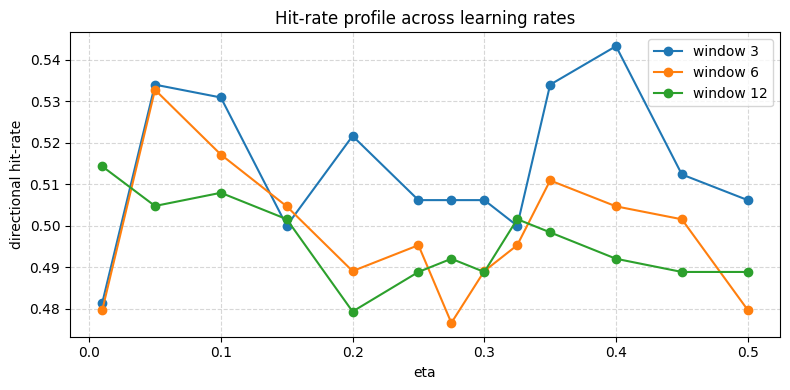

In [26]:
# hit rate vs. eta hyperparam
fig, ax = plt.subplots(figsize=(8, 4))
for w, sub in eval_tbl.groupby("window"):
    ax.plot(sub["eta"], sub["HitRate"], marker="o", label=f"window {w}")
ax.set_xlabel("eta")
ax.set_ylabel("directional hit‑rate")
ax.set_title("Hit‑rate profile across learning rates")
ax.grid(True, linestyle="--", alpha=0.5)
ax.legend()
plt.tight_layout()
plt.show()


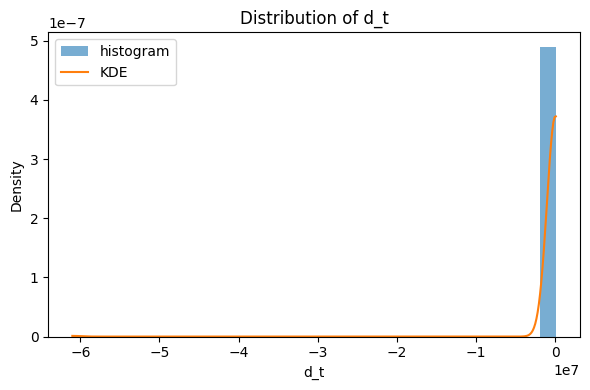

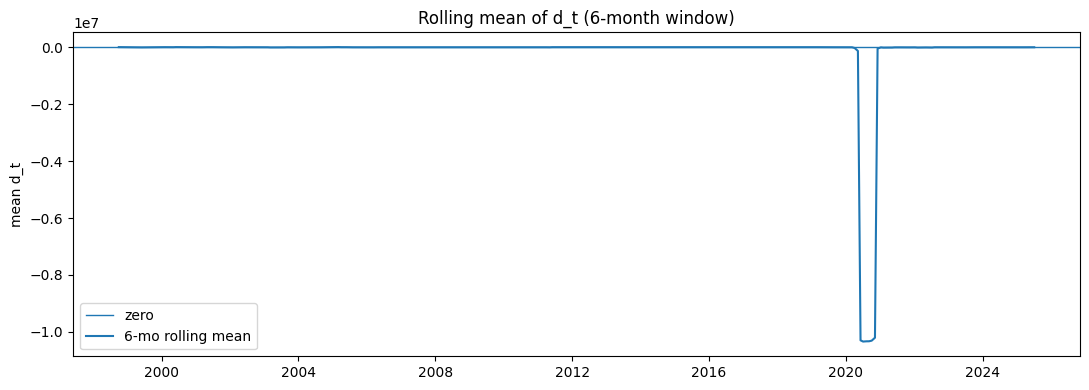

In [37]:
# why is there a RMSE improvement but DM insignificant in full panel? 
# specify MWU config to inspect
window = 3        
eta    = 0.40     

oos = oos_map[(window, eta)].dropna(subset=["actual"]).copy()
oos["date"] = pd.to_datetime(oos["date"])
oos = oos.sort_values("date")

# squared‑error difference  d_t = e^2_MWU − e^2_Median
oos["d_t"] = (oos["mwu"] - oos["actual"])**2 - (oos["median"] - oos["actual"])**2

# Histogram + KDE of d_t
plt.figure(figsize=(6, 4))
plt.hist(oos["d_t"], bins=30, density=True, alpha=0.6, label="histogram")
xs  = np.linspace(oos["d_t"].min(), oos["d_t"].max(), 400)
kde = stats.gaussian_kde(oos["d_t"])
plt.plot(xs, kde(xs), linewidth=1.5, label="KDE")
plt.title("Distribution of d_t")
plt.xlabel("d_t")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()

# Rolling (6‑month) mean of d_t
oos_r = oos.set_index("date")
roll  = oos_r["d_t"].rolling(window=6, min_periods=3).mean()

plt.figure(figsize=(11, 4))
plt.axhline(0, linewidth=1, label="zero")
plt.plot(roll.index, roll, label="6‑mo rolling mean")
plt.title("Rolling mean of d_t (6‑month window)")
plt.ylabel("mean d_t")
plt.legend()
plt.tight_layout()

=== Autocorrelation of d_t ===
lag  1: ρ̂ =  0.011
lag  2: ρ̂ = -0.002
lag  3: ρ̂ = -0.003
lag  4: ρ̂ = -0.003
lag  5: ρ̂ = -0.003
lag  6: ρ̂ = -0.003
lag  7: ρ̂ = -0.003
lag  8: ρ̂ = -0.003
lag  9: ρ̂ = -0.003
lag 10: ρ̂ = -0.003
lag 11: ρ̂ = -0.003
lag 12: ρ̂ = -0.003

=== Ljung‑Box Q‑stat ===
    lb_stat  lb_pvalue
4    0.0485     0.9997
8    0.0611     1.0000
12   0.0752     1.0000

=== Diebold–Mariano ===
Standard   :  DM = -1.015  p = 0.3103
HAC (L=6) :  DM = -1.010  p = 0.3124


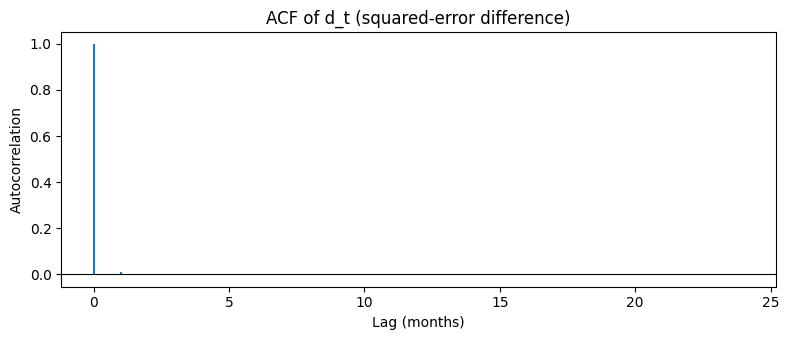

In [35]:
# is there serial correlation in the d_t error series i.e. do we need HAC robust DM statistics? 
# build loss-differential series
oos = oos.copy()                      # make sure we don’t mutate caller
oos["d_t"] = (oos["mwu"] - oos["actual"])**2 - (oos["median"] - oos["actual"])**2
oos = oos.dropna(subset=["d_t"]).sort_values("date")
d_t = oos["d_t"].to_numpy()
T   = len(d_t)

# serial-correlation diagnostics
print("=== Autocorrelation of d_t ===")
for k, r in enumerate(acf(d_t, nlags=12, fft=False)[1:], start=1):
    print(f"lag {k:2d}: ρ̂ = {r: .3f}")

lb_test = acorr_ljungbox(d_t, lags=[4, 8, 12], return_df=True)
print("\n=== Ljung‑Box Q‑stat ===")
print(lb_test.to_string(float_format=lambda x: f"{x:.4f}"))

# DM: HAC vs robust
mean_d  = d_t.mean()
var_iid = d_t.var(ddof=1)
dm_stat = mean_d / np.sqrt(var_iid / T)
dm_p    = 2 * (1 - stats.norm.cdf(abs(dm_stat)))

# Newey–West HAC variance (Bartlett kernel, L = T^(1/3) ↦ round)
L = int(T ** (1 / 3))
gamma = [np.cov(d_t[:-lag], d_t[lag:])[0, 1] if lag else var_iid
         for lag in range(L + 1)]
sigma_hac = gamma[0] + 2 * sum((1 - lag / (L + 1)) * g for lag, g in enumerate(gamma[1:], 1))
dm_hac_stat = mean_d / np.sqrt(sigma_hac / T)
dm_hac_p    = 2 * (1 - stats.norm.cdf(abs(dm_hac_stat)))

print("\n=== Diebold–Mariano ===")
print(f"Standard   :  DM = {dm_stat:6.3f}  p = {dm_p:.4f}")
print(f"HAC (L={L}) :  DM = {dm_hac_stat:6.3f}  p = {dm_hac_p:.4f}")

# quick ACF plot
plt.figure(figsize=(8, 3.5))
acf_vals = acf(d_t, nlags=24, fft=False)
plt.stem(range(len(acf_vals)), acf_vals, markerfmt=" ", basefmt=" ")
plt.axhline(0, color="k", linewidth=0.8)
plt.title("ACF of d_t (squared‑error difference)")
plt.xlabel("Lag (months)")
plt.ylabel("Autocorrelation")
plt.tight_layout()
plt.show()


**Big-picture notes**
- MWU does not beat median in either panel on either point or direction 
- Equal weight median hard to beat in quiet expansions 
- MWU shines during turmoil (possibly, a handful of forecasters picking up on regime changes early and this being reflected in updated weights). Adaptive weights help when environment is volatile. 
- Not a huge correlation between point forecast improvement and directional call 
- Don't need HAC-robust DM. Refer to diagnostic plot above.

### 1.5 Ensemble majority based voting of smart forecasts for directional edge

TODO: is there a smarter/more informed way we can do this? 

**Robust ensemble: inverse MSE + inverse MAE + equal weight (9 method majority vote)**

In [ ]:
# -------------------------------------------------------------
# Robust majority-vote directional back-test
# • Nine smart ensembles: (window ∈ {3,6,12}) × (method ∈ {inv-MSE, inv-MAE, equal})
# • Robust call = majority vote of the nine
# -------------------------------------------------------------
import numpy as np, pandas as pd, warnings, scipy.stats as st
from itertools import product
from tqdm.auto import tqdm

warnings.filterwarnings("ignore")
np.seterr(all="ignore")

# ---------- parameters ---------------------------------------
PANEL       = df_full          # use df_full if you prefer the full sample
WINDOWS     = [3, 6, 12]
METHODS     = ["inverse_mse", "inverse_mae", "equal_weight"]
RIDGE       = 1e-6

# ---------- helper to get weights ---------------------------------
def calc_weights(hist_df: pd.DataFrame, method: str, ridge: float = 1e-6) -> pd.Series:
    """
    hist_df : DataFrame with at least columns ['economist', 'error']
              (already restricted to economists that pass the contiguity rule)
    method  : "equal_weight" | "inverse_mse" | "inverse_mae"
    ridge   : small stabiliser to avoid division-by-zero in inverse weights
    returns : pd.Series indexed by economist with normalised weights that sum to 1
    """
    if method == "equal_weight":
        w = pd.Series(1.0, index=hist_df["economist"].unique())

    else:
        if method == "inverse_mse":
            # mean-squared error per economist
            score = (hist_df.groupby("economist")["error"]
                               .apply(lambda s: np.nanmean(np.square(s))))
        else:                       # "inverse_mae"
            # mean-absolute error per economist
            score = (hist_df.groupby("economist")["error"]
                               .apply(lambda s: np.nanmean(np.abs(s))))

        w = 1.0 / (score + ridge)

    return w / w.sum()


# ---------- main loop ----------------------------------------
dates = np.sort(PANEL["release_date"].unique())
dir_calls = {m: pd.Series(index=dates, dtype="Int64")  # store Beat/Miss per method
             for m in product(WINDOWS, METHODS)}

for win, meth in tqdm(product(WINDOWS, METHODS),
                      total=len(WINDOWS)*len(METHODS),
                      desc="building nine ensembles"):

    for idx in range(win, len(dates)):
        t = dates[idx]
        hist_dates = dates[idx-win:idx]
        hist = PANEL[PANEL["release_date"].isin(hist_dates)]

        # contiguity filter
        elig = (hist.groupby("economist")["forecast"]
                     .apply(lambda s: s.notna().all()))
        econs = elig[elig].index
        if econs.empty:
            continue

        # weights
        w = calc_weights(hist[hist["economist"].isin(econs)], meth)

        # current forecasts
        cur = PANEL[(PANEL["release_date"] == t) &
                    (PANEL["economist"].isin(w.index))]
        f_t = cur.set_index("economist")["forecast"].dropna()
        w   = w.reindex(f_t.index).dropna()
        if w.empty:
            continue
        w /= w.sum()

        smart = np.dot(w, f_t.loc[w.index])
        median = PANEL.loc[PANEL["release_date"] == t,
                           "forecast"].dropna().median()
        dir_calls[(win, meth)].loc[t] = int(smart > median)

# ---------- majority vote & evaluation -----------------------
records = []
for t in dates:
    actual = PANEL.loc[PANEL["release_date"] == t, "actual"].iloc[0]
    median = PANEL.loc[PANEL["release_date"] == t, "forecast"].dropna().median()
    if pd.isna(actual):
        continue                                  # skip unreleased
    actual_dir = int(actual > median)

    votes = [series.get(t, pd.NA) for series in dir_calls.values()]
    votes = [v for v in votes if v is not pd.NA]
    if len(votes) < 9:                            # contiguity gaps
        continue
    robust_dir = int(sum(votes) >= 5)             # majority vote
    records.append(robust_dir == actual_dir)

hits = sum(records)

total = len(records)
print("\nRobust majority-vote back-test")
print(f"  Releases evaluated : {total}")
print(f"  Hits (direction)   : {hits}")
print(f"  Hit rate           : {hits/total:.3f}")


**Robust ensemble: inverse MSE + inverse MAE + soft-BMA (9 method majority vote)**

In [ ]:
import numpy as np, pandas as pd, warnings
from itertools import product
from tqdm.auto import tqdm
from scipy.stats import t as student_t, binomtest

warnings.filterwarnings("ignore")
np.seterr(all="ignore")

# ---------------- CONFIG -------------------------------------------------
WINDOWS  = [3, 6, 12]                       # contiguity windows (months)
METHODS  = ["inverse_mse", "inverse_mae", "soft_bma"]
RIDGE    = 1e-6
NU_SOFT  = 5                                # ν for Student-t soft-BMA
PANEL    = df_full                              # COVID-filtered panel

# ---------------- helper: weighting rules --------------------------------
def calc_weights(hist_df: pd.DataFrame, method: str) -> pd.Series:
    """Return normalised weights (index = economist) for the chosen method."""
    if method == "inverse_mse":
        score = (hist_df.groupby("economist")["error"]
                         .apply(lambda s: np.nanmean(np.square(s))))
        w = 1.0 / (score + RIDGE)

    elif method == "inverse_mae":
        score = (hist_df.groupby("economist")["error"]
                         .apply(lambda s: np.nanmean(np.abs(s))))
        w = 1.0 / (score + RIDGE)

    else:                                    # soft_bma   (Student-t soft-max)
        ll = {}
        for econ, grp in hist_df.groupby("economist"):
            errs = grp["error"].dropna().values
            if errs.size and np.std(errs, ddof=1) > 0:
                ll[econ] = student_t.logpdf(
                    errs, df=NU_SOFT, loc=0, scale=np.std(errs, ddof=1)
                ).sum()
        if ll:
            raw = np.array(list(ll.values()))
            w   = pd.Series(np.exp(raw - raw.max()), index=list(ll.keys()))
        else:                                # fallback: equal weight
            w = pd.Series(1.0, index=hist_df["economist"].unique())

    return w / w.sum()

# ---------------- main loop ----------------------------------------------
dates      = np.sort(PANEL["release_date"].unique())
vote_table = []                              # one row per realised release

for idx, t_date in enumerate(tqdm(dates, desc="Releases")):
    actual_val = PANEL.loc[PANEL["release_date"] == t_date, "actual"].iloc[0]
    if np.isnan(actual_val):                 # skip unreleased month
        continue

    dir_votes = []                           # collect up to 9 votes

    # progress bar for the 3×3 inner loop
    for W, meth in tqdm(product(WINDOWS, METHODS),
                        total=len(WINDOWS)*len(METHODS),
                        leave=False, desc=" combos"):
        if idx < W:                          # need W trailing releases
            continue

        hist = PANEL[PANEL["release_date"].isin(dates[idx-W:idx])]
        # forecasters with complete coverage
        full = (hist.groupby("economist")["forecast"]
                     .apply(lambda s: s.notna().all()))
        econs = full[full].index
        if econs.empty:
            continue

        w = calc_weights(hist[hist["economist"].isin(econs)], meth)

        # current forecasts
        cur = PANEL[(PANEL["release_date"] == t_date) &
                    (PANEL["economist"].isin(w.index))]
        f_t = cur.set_index("economist")["forecast"].dropna()
        w   = w.reindex(f_t.index).dropna()
        if w.empty:
            continue
        w /= w.sum()

        smart  = np.dot(w, f_t.loc[w.index])
        median = PANEL.loc[PANEL["release_date"] == t_date,
                           "forecast"].dropna().median()
        dir_votes.append(int(smart > median))   # 1 = Beat, 0 = Miss

    if dir_votes:                               # majority vote decision
        majority   = int(sum(dir_votes) > len(dir_votes) / 2)
        actual_dir = int(actual_val > median)
        vote_table.append((t_date, majority, actual_dir))

# ---------------- evaluation ---------------------------------------------
vote_df = pd.DataFrame(vote_table,
                       columns=["date", "vote_pred", "actual_dir"])

hits      = (vote_df["vote_pred"] == vote_df["actual_dir"]).sum()
total     = len(vote_df)
hit_rate  = hits / total
p_value   = binomtest(hits, total, 0.5).pvalue

print("\nRobust majority-vote directional back-test")
print(f"  Releases evaluated : {total}")
print(f"  Correct signals    : {hits}")
print(f"  Hit-rate           : {hit_rate:.3f}")
print(f"  Binomial p-value   : {p_value:.4f}")


**Robust ensemble: inverse mse + inverse mae + equal weight + ewma + soft bma**

In [ ]:
import numpy as np, pandas as pd, warnings, scipy.stats as st
from itertools import product
from collections import Counter
from tqdm.auto import tqdm

warnings.filterwarnings("ignore")
np.seterr(all="ignore")

# -------------------------------- user options --------------------------------
PANEL         = df_full              # <- COVID-filtered panel
WINDOWS       = [3, 6, 12]      # months of contiguous history
RIDGE         = 1e-6            # numeric stabiliser
EWMA_LAMBDA   = 0.90            # decay for the EWMA-MSE weighting
T_DF          = 5               # degrees-of-freedom for soft-BMA
# ------------------------------------------------------------------------------

dates = np.sort(PANEL["release_date"].unique())
methods = ["inv_mse", "inv_mae", "equal", "ewma", "soft_bma"]

def calc_weights(hist: pd.DataFrame, method: str) -> pd.Series:
    """Return Series of weights indexed by economist."""
    errs = hist.pivot(index="release_date", columns="economist", values="error")
    # keep only economists with complete window
    errs = errs.dropna(axis=1)
    if errs.empty:
        return pd.Series(dtype=float)

    if method == "equal":
        w = pd.Series(1.0, index=errs.columns)

    elif method in ("inv_mse", "inv_mae"):
        if method == "inv_mse":
            score = (errs**2).mean()
        else:
            score = errs.abs().mean()
        w = 1.0 / (score + RIDGE)

    elif method == "ewma":
        # newest row is last -> weights oldest→newest
        ew = EWMA_LAMBDA ** np.arange(len(errs)-1, -1, -1)
        ew /= ew.sum()
        mse = (errs.pow(2).T @ ew)
        w = 1.0 / (mse + RIDGE)

    elif method == "soft_bma":
        ll = {}
        for econ in errs.columns:
            e = errs[econ].values
            sig = np.std(e, ddof=1)
            if sig > 0:
                ll[econ] = st.t.logpdf(e, df=T_DF, loc=0, scale=sig).sum()
        if not ll:
            return pd.Series(dtype=float)
        raw = np.array(list(ll.values()))
        w = pd.Series(np.exp(raw - raw.max()), index=list(ll.keys()))

    w /= w.sum()
    return w

# containers for evaluation
hits, total = 0, 0
vote_records = []          # optional: see vote composition per release

for idx in tqdm(range(max(WINDOWS), len(dates)), desc="rolling back-test"):
    t_date = dates[idx]

    # skip if actual not yet known
    actual = PANEL.loc[PANEL["release_date"] == t_date, "actual"].iloc[0]
    if np.isnan(actual):
        continue

    median_t = PANEL.loc[PANEL["release_date"] == t_date, "forecast"].dropna().median()
    direction_actual = int(actual > median_t)

    votes = []   # 15 predictions
    for W, meth in product(WINDOWS, methods):
        hist = PANEL[PANEL["release_date"].between(dates[idx-W], dates[idx-1])]
        w = calc_weights(hist, meth)
        if w.empty:                # cannot form forecast -> skip vote
            continue

        cur = PANEL[(PANEL["release_date"] == t_date) &
                    (PANEL["economist"].isin(w.index))]
        f_t = cur.set_index("economist")["forecast"].dropna()
        w   = w.reindex(f_t.index).dropna()
        if w.empty:
            continue
        w /= w.sum()

        smart = np.dot(w, f_t.loc[w.index])
        votes.append(int(smart > median_t))

    if not votes:
        continue                                  # no methods produced a vote

    vote_cnt = Counter(votes)
    robust_dir = 1 if vote_cnt[1] >= 8 else 0     # majority (≥ 8 of 15)

    if robust_dir == direction_actual:
        hits += 1
    total += 1

    vote_records.append({
        "date": t_date, "actual_dir": direction_actual,
        "yes_votes": vote_cnt[1], "no_votes": vote_cnt[0],
        "robust_dir": robust_dir
    })

# ---------------------- summary ----------------------
hit_rate = hits / total if total else np.nan
print(f"\nBack-test period releases evaluated : {total}")
print(f"Robust majority-vote hit rate       : {hit_rate:0.3f}")

# (optional) examine how many yes/no votes per release
vote_df = pd.DataFrame(vote_records).sort_values("date")
# display(vote_df.tail())   # uncomment to inspect the last few rows


**Robust ensemble: equal weight + inverse mse + soft bma + ewma + adp reaction**

In [ ]:
# --------------------------------------------------------------
# Robust-vote experiment for IJC
#   • windows = {6, 12} releases         (≈ 1½ & 3 months)
#   • methods = {equal, inv_mse, soft_bma, ewma, react_adp}
#   • majority-vote = simple >½ rule using **all available votes**
#   • metrics  = directional hit-rate (and crowd-median baseline)
# --------------------------------------------------------------
import numpy as np
import pandas as pd
from itertools import product
from tqdm.auto import tqdm
from scipy.stats import t as student_t, norm, binomtest

# ---------------- helpers -------------------------------------------------
RIDGE      = 1e-6          # small ridge for inverse weights
NU_SOFT    = 5             # ν for soft-BMA Student-t
EWMA_LMBDA = 0.90          # decay factor for EWMA-MSE
ADP_GAP    = 3             # “react-ADP” = revisions ≤ 3 days after ADP

def w_equal(econ_idx):
    """Equal weight."""
    return pd.Series(1 / len(econ_idx), index=econ_idx)

def w_inv_mse(hist):
    score = hist.groupby("economist")["error"].apply(lambda s: np.mean(s**2))
    w = 1 / (score + RIDGE)
    return w / w.sum()

def w_soft_bma(hist):
    ll = {}
    for e, g in hist.groupby("economist"):
        errs = g["error"].dropna().values
        if errs.size and np.std(errs, ddof=1) > 0:
            ll[e] = student_t.logpdf(errs, df=NU_SOFT,
                                     loc=0, scale=np.std(errs, ddof=1)).sum()
    raw = np.array(list(ll.values()))
    w   = pd.Series(np.exp(raw - raw.max()), index=list(ll.keys()))
    return w / w.sum()

def w_ewma(hist):
    n = hist["release_date"].nunique()
    weights_ts = EWMA_LMBDA ** np.arange(n-1, -1, -1);  weights_ts /= weights_ts.sum()
    mse = (hist.pivot(index="release_date", columns="economist", values="error")
                .pow(2).T @ weights_ts)
    w = 1 / (mse + RIDGE)
    return w / w.sum()

def react_to_adp(df_slice):
    """
    Return the *last* forecast per economist that arrived ≤ ADP_GAP days
    before the IJC release; if fewer than 2 such forecasts, return empty.
    """
    cool = (df_slice["release_date"] - df_slice["asof"]).dt.days <= ADP_GAP
    fresh = df_slice[cool]
    fresh = (fresh.sort_values(["economist", "asof"])
                   .groupby("economist", as_index=False).tail(1))
    return fresh

# mapping of method → weighting function
WEIGHT_FUNCS = {"equal": w_equal,
                "inv_mse": w_inv_mse,
                "soft_bma": w_soft_bma,
                "ewma": w_ewma}

# ---------------- experiment setup ----------------------------------------
WINDOWS   = [6, 12]
ALL_METHS = list(WEIGHT_FUNCS) + ["react_adp"]   # total = 5 votes
PANEL     = df_full.copy()                       # full IJC panel

dates  = np.sort(PANEL["release_date"].unique())
scores = {W: {m: [] for m in ALL_METHS + ["majority_vote"]} for W in WINDOWS}

for W in WINDOWS:
    for idx in tqdm(range(W, len(dates)), desc=f"window {W}"):
        t_date = dates[idx]
        actual = PANEL.loc[PANEL["release_date"] == t_date, "actual"].iloc[0]
        if pd.isna(actual):            # unreleased week
            continue
        crowd_med = PANEL.loc[PANEL["release_date"] == t_date,
                              "forecast"].dropna().median()
        votes = []

        # -------- loop over the five forecasting rules --------
        for meth in ALL_METHS:
            if meth == "react_adp":
                cur = react_to_adp(PANEL[PANEL["release_date"] == t_date])
                if len(cur) < 2:       # need ≥2 “fresh” forecasts
                    continue
                smart = cur["forecast"].mean()   # simple mean
            else:
                hist = PANEL[PANEL["release_date"].isin(dates[idx-W:idx])]
                # contiguity filter
                elig = hist.groupby("economist")["forecast"].apply(lambda s: s.notna().all())
                econs = elig[elig].index
                if econs.empty:
                    continue
                if meth == "equal":
                    w = w_equal(econs)
                else:
                    w = WEIGHT_FUNCS[meth](hist[hist["economist"].isin(econs)])

                # current forecasts aligned with weight index
                cur = PANEL[(PANEL["release_date"] == t_date) &
                            (PANEL["economist"].isin(w.index))]
                f_t = cur.set_index("economist")["forecast"].dropna()
                w   = w.reindex(f_t.index).dropna()
                if w.empty:
                    continue
                w /= w.sum()
                smart = np.dot(w, f_t.loc[w.index])

            # directional vote & score storage
            hit = int((smart > crowd_med) == (actual > crowd_med))
            scores[W][meth].append(hit)
            votes.append(int(smart > crowd_med))

        # ------- majority vote (needs ≥2 ballots) --------------
        if len(votes) >= 2:
            maj_pred = int(sum(votes) > len(votes) / 2)
            maj_hit  = int(maj_pred == (actual > crowd_med))
            scores[W]["majority_vote"].append(maj_hit)

# ---------------- results table ------------------------------------------
print("\n=== Directional hit-rates ===")
for W in WINDOWS:
    print(f"\nWindow {W} releases")
    rows = []
    for m, hits in scores[W].items():
        if hits:                         # avoid empty lists
            rows.append((m, np.mean(hits)))
    out = (pd.DataFrame(rows, columns=["method", "HitRate"])
             .sort_values("method")
             .to_string(index=False, float_format="{:.3f}".format))
    print(out)


**Display all live forecasts for upcoming print**

In [ ]:
def display_live(df):
    """
    Helper to display all current live forecasts neatly. 
    """
    wide = pd.json_normalize(df.to_dict(orient="records"))
    cols = ["model_id", "panel", "criterion", "date",
            "smart", "median", "signal"] + \
           [c for c in wide.columns if c.startswith("params.")]
    return (wide[cols]
            .rename(columns=lambda c: c.replace("params.", ""))  # drop prefix
            .sort_values(["date", "model_id"]))

In [ ]:
display_live(pd.DataFrame(live_forecasts))

,model_id,panel,criterion,date,smart,median,signal
0,inv_err,COVID,Lowest RMSE,2025-08-01,106.180,110.000,Miss
1,inv_err,COVID,Highest HitRate & Robust Winner,2025-08-01,106.000,110.000,Miss
2,inv_err,Full,Lowest RMSE,2025-08-01,108.689,110.000,Miss
3,inv_err,Full,Highest HitRate,2025-08-01,106.000,110.000,Miss
4,inv_err,COVID,Lowest RMSE,2025-08-01,106.180,110.000,Miss
5,inv_err,COVID,Highest HitRate & Robust Winner,2025-08-01,106.000,110.000,Miss
6,inv_err,Full,Lowest RMSE,2025-08-01,108.689,110.000,Miss
7,inv_err,Full,Highest HitRate,2025-08-01,106.000,110.000,Miss


## 2 Distributional forecasting

We deploy the following distributional forecasting methods to quantify forecast uncertainty
1. Student-t fitted to past errors
2. t-GARCH: Rolling-36 GARCH(1,1) with Student-t innovations 
3. Gaussian Mixture Models
4. Bayesian Model Averaging
5. Kalman filter (TODO)

### 2.1 Student-t error bands

In [43]:
# settings
ROLL_WIN   = 36
MIN_TRAIN  = 36
LEVELS     = np.array([.50,.60,.70,.80,.90,.95])
BETA_BASE  = 0.0
BETA_CRIS  = 0.80
PCTL_THRES = 0.95
LAMBDA     = 1.0
PANELS     = {"COVID": df, "Full": df_full}

warnings.filterwarnings("ignore")
np.seterr(all="ignore")

ci_half = lambda lvl, df_, sig: st.t.ppf(1-(1-lvl)/2, df=df_)*sig

# ---------------------------------------------------------------------
# Candidate spec grid  (name, window_type, use_mu_shift)
# CrisisAdj toggled later so we get 9 total variants
# ---------------------------------------------------------------------
SPEC_BASE = [
    ("Exp_noShift" , "expanding", False),
    ("Roll36_noShift", "rolling", False),
    ("Roll36_plusMu" , "rolling", True ),
]

# Build a reverse‑lookup to reconstruct settings from a tag --------
spec_params = {}
for nm, wt, um in SPEC_BASE:
    for crisis in (False, True):
        tag = f"{nm}_{'Yes' if crisis else 'No'}"
        spec_params[tag] = dict(name=nm, wtype=wt,
                                use_mu=um, crisis=crisis)

# =====================================================================
# BACKTEST  (both panels, all tags)
# =====================================================================
cov_rows, gap_rows = [], []

for p_label, panel in PANELS.items():
    # per‑release aggregates ------------------------------------------
    rel = (panel.groupby("release_date")
                 .agg(median_fc=("median_forecast","median"),
                      actual    =("actual","first"),
                      spread    =("forecast","std"))
                 .reset_index()
                 .sort_values("release_date"))
    rel["err"] = rel["median_fc"] - rel["actual"]
    eval_df = rel[rel["actual"].notna()].reset_index(drop=True)

    for nm, wtype, use_mu in SPEC_BASE:
        for crisis in (False, True):
            tag   = f"{nm}_{'Yes' if crisis else 'No'}"
            hits  = defaultdict(int);  totN = 0

            for i in tqdm(range(MIN_TRAIN, len(eval_df)),
                          desc=f"{p_label} | {tag}", leave=False):

                # training window -----------------------------------
                if wtype == "expanding":
                    errs = eval_df.loc[:i-1, "err"].values
                    sprd = eval_df.loc[:i-1, "spread"].values
                else:
                    if i < ROLL_WIN:  continue
                    errs = eval_df.loc[i-ROLL_WIN:i-1, "err"].values
                    sprd = eval_df.loc[i-ROLL_WIN:i-1, "spread"].values

                nu, mu, sig = st.t.fit(errs)

                pt      = eval_df.at[i, "median_fc"]
                act     = eval_df.at[i, "actual"]
                sp_t    = eval_df.at[i, "spread"]

                # crisis multiplier -------------------------------
                if crisis:
                    med_sp = np.median(sprd)
                    pct    = (sprd < sp_t).mean()
                    beta   = BETA_BASE if pct < PCTL_THRES else BETA_CRIS
                    mult   = (sp_t/med_sp)**beta
                else:
                    mult   = 1.0

                centre = pt + (mu if use_mu else 0.0)

                for L in LEVELS:
                    h = ci_half(L, nu, sig)*mult
                    if centre-h <= act <= centre+h:
                        hits[L] += 1
                totN += 1

            if totN == 0:  continue
            emp = np.array([hits[L]/totN for L in LEVELS])
            for L, e in zip(LEVELS, emp):
                cov_rows.append(dict(Panel=p_label, Spec=tag,
                                     Nominal=L, Empirical=e))
            gap_rows.append(dict(Panel=p_label, Spec=tag,
                                 AvgAbsGap=float(np.abs(emp-LEVELS).mean())))

# ------------ tidy back‑test tables ---------------------------
cov_tbl = (pd.DataFrame(cov_rows)
             .pivot_table(index=["Panel","Spec"],
                          columns="Nominal", values="Empirical")
             .sort_index())

gap_tbl = (pd.DataFrame(gap_rows)
             .set_index(["Panel","Spec"])
             .sort_index())

print("\n=== Back‑test coverage (Student‑t) ===")
print(cov_tbl)
print("\nMean‑absolute coverage gap (lower = better):")
print(gap_tbl)

# =====================================================================
# pick best spec
# =====================================================================
best_row = (gap_tbl.xs("Full")
                     .sort_values("AvgAbsGap")
                     .iloc[0])
best_tag = best_row.name         # MultiIndex -> tag str
best_cfg = spec_params[best_tag]

print("\n>>> Best spec on FULL panel <<<")
print(f"  Tag          : {best_tag}")
print(f"  Window type  : {best_cfg['wtype']}")
print(f"  μ‑shift      : {best_cfg['use_mu']}")
print(f"  CrisisAdj    : {best_cfg['crisis']}")
print(f"  AvgAbsGap    : {best_row['AvgAbsGap']:.4f}")

# =====================================================================
# helper to compute half‑width multiplier  (crisis / no‑crisis)
# =====================================================================
def crisis_mult(sp_hist, sp_t, crisis_flag):
    if not crisis_flag:
        return 1.0
    med_sp = np.median(sp_hist)
    pct    = (sp_hist < sp_t).mean()
    beta   = BETA_BASE if pct < PCTL_THRES else BETA_CRIS
    return (sp_t / med_sp) ** beta

# =====================================================================
# STRATIFIED (best spec)
# =====================================================================
print("\n=== Stratified 4‑block results (best spec) ===")
cov_rows, gap_rows = [], []

for p_label, panel in PANELS.items():
    rel = (panel.groupby("release_date")
                 .agg(median_fc=("median_forecast", "median"),
                      actual    =("actual",          "first"),
                      spread    =("forecast",        "std"))
                 .reset_index()
                 .sort_values("release_date"))
    rel = rel[rel["actual"].notna()].reset_index(drop=True)
    rel["err"] = rel["median_fc"] - rel["actual"]

    idx_eval = np.arange(MIN_TRAIN, len(rel))
    blocks   = np.array_split(idx_eval, 4)

    g_hits = defaultdict(int); g_tot = 0

    for b_no, idx in enumerate(blocks, 1):
        hits = defaultdict(int); tot = 0
        st_dt = rel.at[idx[0], "release_date"].date()
        en_dt = rel.at[idx[-1], "release_date"].date()

        for j in tqdm(idx, desc=f"{p_label} | Blk{b_no}", leave=False):
            # training window per spec ---------------------------
            if best_cfg['wtype'] == "expanding":
                err_h = rel.loc[:j-1, "err"].values
                sp_h  = rel.loc[:j-1, "spread"].values
            else:                                           # rolling‑36
                if j < ROLL_WIN:  continue
                err_h = rel.loc[j-ROLL_WIN:j-1, "err"].values
                sp_h  = rel.loc[j-ROLL_WIN:j-1, "spread"].values

            nu, mu, sig = st.t.fit(err_h)

            centre  = rel.at[j, "median_fc"] + (mu if best_cfg['use_mu'] else 0.0)
            actual  = rel.at[j, "actual"]
            sp_t    = rel.at[j, "spread"]
            mult    = crisis_mult(sp_h, sp_t, best_cfg['crisis'])

            for L in LEVELS:
                h = ci_half(L, nu, sig) * mult
                hit = int(centre - h <= actual <= centre + h)
                hits[L]   += hit
                g_hits[L] += hit
            tot   += 1
            g_tot += 1

        emp = np.array([hits[L] / tot for L in LEVELS])
        cov_rows.extend([dict(Panel=p_label, Block=b_no,
                              Start=st_dt, End=en_dt,
                              Nominal=L, Empirical=e)
                         for L, e in zip(LEVELS, emp)])
        gap_rows.append(dict(Panel=p_label, Block=b_no,
                             Start=st_dt, End=en_dt,
                             AvgAbsGap=float(np.abs(emp - LEVELS).mean())))

    # global “All” row
    emp_all = np.array([g_hits[L] / g_tot for L in LEVELS])
    cov_rows.extend([dict(Panel=p_label, Block="All",
                          Start=rel.iloc[0]["release_date"].date(),
                          End  =rel.iloc[-1]["release_date"].date(),
                          Nominal=L, Empirical=e)
                     for L, e in zip(LEVELS, emp_all)])
    gap_rows.append(dict(Panel=p_label, Block="All",
                         Start=rel.iloc[0]["release_date"].date(),
                         End  =rel.iloc[-1]["release_date"].date(),
                         AvgAbsGap=float(np.abs(emp_all - LEVELS).mean())))

# ---------- tidy + print ----------
cov_tbl_blk = (pd.DataFrame(cov_rows)
                 .pivot_table(index=["Panel", "Block", "Start", "End"],
                              columns="Nominal", values="Empirical")
                 .sort_index())
gap_df      = pd.DataFrame(gap_rows)
gap_tbl_blk = (gap_df.set_index(["Panel", "Block", "Start", "End"])
                        .sort_index())

print(cov_tbl_blk)
print("\nMean‑absolute gap by block:")
print(gap_tbl_blk)

# ---------- ACCURACY × CONSISTENCY score ----------
score_rows = []
for p, grp in gap_df.groupby("Panel"):
    mag_all = grp.loc[grp["Block"] == "All", "AvgAbsGap"].item()
    sd_blk  = grp.loc[grp["Block"].isin([1, 2, 3, 4]), "AvgAbsGap"].std(ddof=1)
    score_rows.append({"Panel": p,
                       "MAG_All": mag_all,
                       "SD_blocks": sd_blk,
                       f"Score(λ={LAMBDA})": mag_all + LAMBDA * sd_blk})

score_tbl = pd.DataFrame(score_rows).set_index("Panel")

print("\nAccuracy × Consistency summary (lower = better):")
print(score_tbl)


# live CI (if applicable)
print("\n=== Live CI using best spec ===")
for p_label, panel in PANELS.items():
    unreleased = panel[panel["actual"].isna()].sort_values("release_date")
    if unreleased.empty:
        print(f"{p_label}: no unreleased month.")
        continue

    row      = unreleased.iloc[-1]
    t_date   = row["release_date"].date()
    pt_med   = row["median_forecast"]
    sp_t     = row["forecast"].std()

    # history window
    hist = (panel[(panel["release_date"] < row["release_date"]) &
                  panel["actual"].notna()]
            .groupby("release_date")
            .agg(median_fc=("median_forecast","first"),
                 actual    =("actual","first"),
                 spread    =("forecast","std"))
            .tail(ROLL_WIN if best_cfg['wtype']=="rolling" else None))

    if len(hist) < MIN_TRAIN:
        print(f"{p_label}: not enough history for live CI.")
        continue

    hist["err"] = hist["median_fc"] - hist["actual"]
    nu, mu, sig = st.t.fit(hist["err"].values)

    centre = pt_med + (mu if best_cfg['use_mu'] else 0.0)
    mult   = crisis_mult(hist["spread"].values, sp_t, best_cfg['crisis'])

    print(f"{p_label} | {t_date}  median = {pt_med:,.0f} k")
    for L in (.50,.60,.70,.80,.90,.95):
        h = ci_half(L, nu, sig)*mult
        print(f"  {int(L*100)}% band : [{centre-h:,.0f} , {centre+h:,.0f}] k")
    print()


COVID | Exp_noShift_No:   0%|          | 0/194 [00:00<?, ?it/s]

COVID | Exp_noShift_Yes:   0%|          | 0/194 [00:00<?, ?it/s]

COVID | Roll36_noShift_No:   0%|          | 0/194 [00:00<?, ?it/s]

COVID | Roll36_noShift_Yes:   0%|          | 0/194 [00:00<?, ?it/s]

COVID | Roll36_plusMu_No:   0%|          | 0/194 [00:00<?, ?it/s]

COVID | Roll36_plusMu_Yes:   0%|          | 0/194 [00:00<?, ?it/s]

Full | Exp_noShift_No:   0%|          | 0/291 [00:00<?, ?it/s]

Full | Exp_noShift_Yes:   0%|          | 0/291 [00:00<?, ?it/s]

Full | Roll36_noShift_No:   0%|          | 0/291 [00:00<?, ?it/s]

Full | Roll36_noShift_Yes:   0%|          | 0/291 [00:00<?, ?it/s]

Full | Roll36_plusMu_No:   0%|          | 0/291 [00:00<?, ?it/s]

Full | Roll36_plusMu_Yes:   0%|          | 0/291 [00:00<?, ?it/s]


=== Back‑test coverage (Student‑t) ===
Nominal                       0.50      0.60      0.70      0.80      0.90  \
Panel Spec                                                                   
COVID Exp_noShift_No      0.561856  0.639175  0.706186  0.840206  0.932990   
      Exp_noShift_Yes     0.577320  0.649485  0.716495  0.850515  0.932990   
      Roll36_noShift_No   0.510309  0.592784  0.675258  0.773196  0.896907   
      Roll36_noShift_Yes  0.525773  0.618557  0.695876  0.783505  0.907216   
      Roll36_plusMu_No    0.494845  0.577320  0.654639  0.742268  0.871134   
      Roll36_plusMu_Yes   0.505155  0.603093  0.670103  0.768041  0.881443   
Full  Exp_noShift_No      0.536082  0.628866  0.728522  0.835052  0.903780   
      Exp_noShift_Yes     0.573883  0.663230  0.773196  0.876289  0.945017   
      Roll36_noShift_No   0.505155  0.591065  0.680412  0.786942  0.907216   
      Roll36_noShift_Yes  0.522337  0.615120  0.701031  0.800687  0.920962   
      Roll36_plusMu_No  

COVID | Blk1:   0%|          | 0/49 [00:00<?, ?it/s]

COVID | Blk2:   0%|          | 0/49 [00:00<?, ?it/s]

COVID | Blk3:   0%|          | 0/48 [00:00<?, ?it/s]

COVID | Blk4:   0%|          | 0/48 [00:00<?, ?it/s]

Full | Blk1:   0%|          | 0/73 [00:00<?, ?it/s]

Full | Blk2:   0%|          | 0/73 [00:00<?, ?it/s]

Full | Blk3:   0%|          | 0/73 [00:00<?, ?it/s]

Full | Blk4:   0%|          | 0/72 [00:00<?, ?it/s]

Nominal                                0.50      0.60      0.70      0.80  \
Panel Block Start      End                                                  
COVID 1     2006-06-02 2010-06-04  0.551020  0.591837  0.673469  0.734694   
      2     2010-07-02 2014-07-03  0.530612  0.591837  0.673469  0.795918   
      3     2014-08-01 2018-07-06  0.500000  0.666667  0.708333  0.770833   
      4     2018-08-03 2025-07-03  0.458333  0.520833  0.645833  0.791667   
      All   2003-06-06 2025-07-03  0.510309  0.592784  0.675258  0.773196   
Full  1     2001-05-04 2007-05-04  0.547945  0.643836  0.739726  0.849315   
      2     2007-06-01 2013-06-07  0.493151  0.547945  0.643836  0.726027   
      3     2013-07-05 2019-07-05  0.479452  0.602740  0.671233  0.753425   
      4     2019-08-02 2025-07-03  0.500000  0.569444  0.666667  0.819444   
      All   1997-08-01 2025-07-03  0.505155  0.591065  0.680412  0.786942   

Nominal                                0.90      0.95  
Panel Block Start  

### 2.2 GARCH(1,1)

TODO: consider whether or not to implement expanding (better justified?) vs rolling 

In [47]:
# ───────── global settings ─────────────────────────────────────
warnings.filterwarnings("ignore", category=ConvergenceWarning)
np.seterr(all="ignore")

ROLL_WIN   = 36                       # rolling window length
MIN_TRAIN  = 36                       # first release scored
LEVELS     = np.array([.50,.60,.70,.80,.90,.95])
BETA_BASE  = 0.0                      # crisis spread‑elasticity
BETA_CRIS  = 0.80
PCTL_THRES = 0.95                     # top‑5 % spread ⇒ crisis
LAMBDA     = 1.0                      # weight for consistency score
SCALE      = 1_000.0                  # k‑jobs → hundreds
PANELS     = {"COVID": df, "Full": df_full}

# ───────── helpers ─────────────────────────────────────────────
def ci_half(level: float, nu: float, sigma: float) -> float:
    """Half‑width of two‑sided Student‑t interval (ν = nu, σ = sigma)."""
    return st.t.ppf(1 - (1 - level) / 2, df=nu) * sigma

def garch_one_step(rescaled_errs: np.ndarray):
    """
    Fit Constant‑Mean + GARCH(1,1)‑t on *rescaled* errors and return
    one‑step‑ahead (ν, σ̂ₜ₊₁, μ̂ₜ₊₁) in ORIGINAL units.
    """
    mdl = ConstantMean(rescaled_errs, rescale=False)
    mdl.volatility   = GARCH(1, 1)
    mdl.distribution = StudentsT()
    res = mdl.fit(disp="off")
    fc  = res.forecast(horizon=1)
    mu  = fc.mean.iloc[-1, 0] * SCALE
    sig = math.sqrt(fc.variance.iloc[-1, 0]) * SCALE
    nu  = res.params["nu"]
    return nu, sig, mu

def crisis_mult(sp_hist, sp_t, crisis_flag: bool) -> float:
    """Spread‑based crisis multiplier (1 if crisis_flag is False)."""
    if not crisis_flag:
        return 1.0
    med_sp = np.median(sp_hist)
    pct    = (sp_hist < sp_t).mean()
    beta   = BETA_BASE if pct < PCTL_THRES else BETA_CRIS
    return (sp_t / med_sp) ** beta

# ================================================================
# BACK‑TEST – both panels, two specs (NoAdj / CrisisAdj)
# ================================================================
cov_rows, gap_rows = [], []

for p_label, panel in PANELS.items():
    # ─── per‑release aggregates ────────────────────────────────
    rel = (panel.groupby("release_date")
                 .agg(median_fc=("median_forecast", "first"),
                      actual    =("actual",          "first"),
                      spread    =("forecast",        "std"))
                 .reset_index()
                 .sort_values("release_date"))
    rel = rel[rel["actual"].notna()].reset_index(drop=True)
    rel["err"] = rel["median_fc"] - rel["actual"]

    for crisis_flag in (False, True):
        tag   = f"GARCH_{'CrisisAdj' if crisis_flag else 'NoAdj'}"
        hits  = defaultdict(int); totN = 0

        for i in tqdm(range(MIN_TRAIN, len(rel)),
                      desc=f"{p_label} | {tag}", leave=False):
            # ─── training window ────────────────────────────────
            start = max(0, i - ROLL_WIN) 
            errs  = rel.loc[start:i-1, "err"].values / SCALE
            nu, sig_fc, mu_fc = garch_one_step(errs)

            centre   = rel.at[i, "median_fc"] + mu_fc   # μ‑shift always on
            actual   = rel.at[i, "actual"]
            sp_t     = rel.at[i, "spread"]
            mult     = crisis_mult(rel.loc[start:i-1, "spread"].values,
                                   sp_t, crisis_flag)

            for L in LEVELS:
                if centre - ci_half(L, nu, sig_fc)*mult <= actual <= \
                   centre + ci_half(L, nu, sig_fc)*mult:
                    hits[L] += 1
            totN += 1

        # ─── store results ─────────────────────────────────────
        emp_vec = np.array([hits[L] / totN for L in LEVELS])
        for L, e in zip(LEVELS, emp_vec):
            cov_rows.append(dict(Panel=p_label, Spec=tag,
                                 Nominal=L, Empirical=e))
        gap_rows.append(dict(Panel=p_label, Spec=tag,
                             AvgAbsGap=float(np.abs(emp_vec - LEVELS).mean())))

# ─── tidy & print back‑test tables ─────────────────────────────
cov_tbl = (pd.DataFrame(cov_rows)
             .pivot_table(index=["Panel", "Spec"],
                          columns="Nominal", values="Empirical")
             .sort_index())
gap_tbl = (pd.DataFrame(gap_rows)
             .set_index(["Panel", "Spec"])
             .sort_index())

pd.set_option("display.float_format", "{:.3f}".format)
print("\n=== Back‑test coverage (GARCH(1,1)‑t) ===")
print(cov_tbl)
print("\nMean‑absolute coverage gap (lower = better):")
print(gap_tbl)

# ================================================================
# Pick best spec on FULL panel
# ================================================================
best_row = (gap_tbl.xs("Full")
                     .sort_values("AvgAbsGap")
                     .iloc[0])
best_tag  = best_row.name
best_cfg  = dict(crisis = "CrisisAdj" in best_tag)

print("\n>>> Best spec on FULL panel <<<")
print(f"  Tag        : {best_tag}")
print(f"  CrisisAdj  : {best_cfg['crisis']}")
print(f"  AvgAbsGap  : {best_row['AvgAbsGap']:.4f}")

# ================================================================
# STRATIFIED ANALYSIS  (using best spec)
# ================================================================
print("\n=== Stratified 4‑block results (best spec) ===")
cov_rows, gap_rows = [], []

for p_label, panel in PANELS.items():
    rel = (panel.groupby("release_date")
                 .agg(median_fc=("median_forecast", "first"),
                      actual    =("actual",          "first"),
                      spread    =("forecast",        "std"))
                 .reset_index()
                 .sort_values("release_date"))
    rel = rel[rel["actual"].notna()].reset_index(drop=True)
    rel["err"] = rel["median_fc"] - rel["actual"]

    idx_eval = np.arange(MIN_TRAIN, len(rel))
    blocks   = np.array_split(idx_eval, 4)

    g_hits = defaultdict(int); g_tot = 0

    for b_no, idx in enumerate(blocks, 1):
        hits = defaultdict(int); tot = 0
        st_dt = rel.at[idx[0], "release_date"].date()
        en_dt = rel.at[idx[-1], "release_date"].date()

        for j in tqdm(idx, desc=f"{p_label} | Blk{b_no}", leave=False):
            start = max(0, j - ROLL_WIN)
            errs  = rel.loc[start:j-1, "err"].values / SCALE
            nu, sig_fc, mu_fc = garch_one_step(errs)

            centre = rel.at[j, "median_fc"] + mu_fc
            actual = rel.at[j, "actual"]
            sp_t   = rel.at[j, "spread"]
            mult   = crisis_mult(rel.loc[start:j-1, "spread"].values,
                                 sp_t, best_cfg['crisis'])

            for L in LEVELS:
                hit = centre - ci_half(L, nu, sig_fc)*mult <= actual <= \
                      centre + ci_half(L, nu, sig_fc)*mult
                hits[L]   += hit
                g_hits[L] += hit
            tot += 1
            g_tot += 1

        emp_vec = np.array([hits[L] / tot for L in LEVELS])
        cov_rows.extend([dict(Panel=p_label, Block=b_no,
                              Start=st_dt, End=en_dt,
                              Nominal=L, Empirical=e)
                         for L, e in zip(LEVELS, emp_vec)])
        gap_rows.append(dict(Panel=p_label, Block=b_no,
                             Start=st_dt, End=en_dt,
                             AvgAbsGap=float(np.abs(emp_vec - LEVELS).mean())))

    # global “All”
    emp_all = np.array([g_hits[L] / g_tot for L in LEVELS])
    cov_rows.extend([dict(Panel=p_label, Block="All",
                          Start=rel.iloc[0]["release_date"].date(),
                          End  =rel.iloc[-1]["release_date"].date(),
                          Nominal=L, Empirical=e)
                     for L, e in zip(LEVELS, emp_all)])
    gap_rows.append(dict(Panel=p_label, Block="All",
                         Start=rel.iloc[0]["release_date"].date(),
                         End  =rel.iloc[-1]["release_date"].date(),
                         AvgAbsGap=float(np.abs(emp_all - LEVELS).mean())))

cov_tbl_blk = (pd.DataFrame(cov_rows)
                 .pivot_table(index=["Panel","Block","Start","End"],
                              columns="Nominal", values="Empirical")
                 .sort_index())
gap_df      = pd.DataFrame(gap_rows)
gap_tbl_blk = (gap_df.set_index(["Panel","Block","Start","End"])
                        .sort_index())

print(cov_tbl_blk)
print("\nMean‑absolute gap by block:")
print(gap_tbl_blk)

# ─── Accuracy × Consistency score ──────────────────────────────
score_rows = []
for p, grp in gap_df.groupby("Panel"):
    mag_all = grp.loc[grp["Block"]=="All", "AvgAbsGap"].item()
    sd_blk  = grp.loc[grp["Block"].isin([1,2,3,4]), "AvgAbsGap"].std(ddof=1)
    score_rows.append({"Panel": p,
                       "MAG_All": mag_all,
                       "SD_blocks": sd_blk,
                       f"Score(λ={LAMBDA})": mag_all + LAMBDA*sd_blk})
score_tbl = pd.DataFrame(score_rows).set_index("Panel")

print("\nAccuracy × Consistency summary (lower = better):")
print(score_tbl)

# ================================================================
# LIVE CI for unreleased month (best spec)
# ================================================================
print("\n=== Live CI using best GARCH spec ===")
for p_label, panel in PANELS.items():
    unreleased = panel[panel["actual"].isna()].sort_values("release_date")
    if unreleased.empty:
        print(f"{p_label}: no unreleased month.")
        continue

    row    = unreleased.iloc[-1]
    t_date = row["release_date"].date()
    pt_med = row["median_forecast"]
    sp_t   = row["forecast"].std()

    # history window
    hist = (panel[(panel["release_date"] < row["release_date"]) &
                  panel["actual"].notna()]
            .groupby("release_date")
            .agg(median_fc=("median_forecast","first"),
                 actual    =("actual","first"),
                 spread    =("forecast","std"))
            .tail(ROLL_WIN))
    if len(hist) < MIN_TRAIN:
        print(f"{p_label}: not enough history for live CI.")
        continue

    hist["err"] = hist["median_fc"] - hist["actual"]
    nu, sig_fc, mu_fc = garch_one_step(hist["err"].values / SCALE)

    centre = pt_med + mu_fc
    mult   = crisis_mult(hist["spread"].values, sp_t, best_cfg['crisis'])

    print(f"{p_label} | {t_date}  median = {pt_med:,.0f} k")
    for L in LEVELS:
        h = ci_half(L, nu, sig_fc) * mult
        print(f"  {int(L*100)}% band : [{centre-h:,.0f} , {centre+h:,.0f}] k")
    print()


COVID | GARCH_NoAdj:   0%|          | 0/194 [00:00<?, ?it/s]

c:\Users\nwong\AppData\Local\Programs\Python\Python313\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


COVID | GARCH_CrisisAdj:   0%|          | 0/194 [00:00<?, ?it/s]

c:\Users\nwong\AppData\Local\Programs\Python\Python313\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Full | GARCH_NoAdj:   0%|          | 0/291 [00:00<?, ?it/s]

c:\Users\nwong\AppData\Local\Programs\Python\Python313\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Full | GARCH_CrisisAdj:   0%|          | 0/291 [00:00<?, ?it/s]

c:\Users\nwong\AppData\Local\Programs\Python\Python313\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(



=== Back‑test coverage (GARCH(1,1)‑t) ===
Nominal                0.500  0.600  0.700  0.800  0.900  0.950
Panel Spec                                                     
COVID GARCH_CrisisAdj  0.500  0.598  0.675  0.784  0.887  0.938
      GARCH_NoAdj      0.485  0.588  0.665  0.778  0.876  0.933
Full  GARCH_CrisisAdj  0.498  0.608  0.687  0.787  0.883  0.928
      GARCH_NoAdj      0.474  0.591  0.670  0.773  0.866  0.914

Mean‑absolute coverage gap (lower = better):
                       AvgAbsGap
Panel Spec                      
COVID GARCH_CrisisAdj      0.011
      GARCH_NoAdj          0.021
Full  GARCH_CrisisAdj      0.012
      GARCH_NoAdj          0.027

>>> Best spec on FULL panel <<<
  Tag        : GARCH_CrisisAdj
  CrisisAdj  : True
  AvgAbsGap  : 0.0125

=== Stratified 4‑block results (best spec) ===


COVID | Blk1:   0%|          | 0/49 [00:00<?, ?it/s]

c:\Users\nwong\AppData\Local\Programs\Python\Python313\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


COVID | Blk2:   0%|          | 0/49 [00:00<?, ?it/s]

COVID | Blk3:   0%|          | 0/48 [00:00<?, ?it/s]

COVID | Blk4:   0%|          | 0/48 [00:00<?, ?it/s]

Full | Blk1:   0%|          | 0/73 [00:00<?, ?it/s]

c:\Users\nwong\AppData\Local\Programs\Python\Python313\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Full | Blk2:   0%|          | 0/73 [00:00<?, ?it/s]

Full | Blk3:   0%|          | 0/73 [00:00<?, ?it/s]

Full | Blk4:   0%|          | 0/72 [00:00<?, ?it/s]

Nominal                            0.500  0.600  0.700  0.800  0.900  0.950
Panel Block Start      End                                                 
COVID 1     2006-06-02 2010-06-04  0.469  0.531  0.633  0.776  0.857  0.898
      2     2010-07-02 2014-07-03  0.490  0.633  0.653  0.776  0.918  0.959
      3     2014-08-01 2018-07-06  0.521  0.646  0.708  0.792  0.875  0.958
      4     2018-08-03 2025-07-03  0.521  0.583  0.708  0.792  0.896  0.938
      All   2003-06-06 2025-07-03  0.500  0.598  0.675  0.784  0.887  0.938
Full  1     2001-05-04 2007-05-04  0.425  0.534  0.644  0.726  0.808  0.877
      2     2007-06-01 2013-06-07  0.493  0.603  0.658  0.795  0.904  0.945
      3     2013-07-05 2019-07-05  0.466  0.589  0.658  0.753  0.849  0.918
      4     2019-08-02 2025-07-03  0.611  0.708  0.792  0.875  0.972  0.972
      All   1997-08-01 2025-07-03  0.498  0.608  0.687  0.787  0.883  0.928

Mean‑absolute gap by block:
                                   AvgAbsGap
Panel Block St

### 2.3 Gaussian Mixture Model

- Prep. series of median residuals 
- Fit a GMM to the chosen window (either trailing 36 releases or full history if expanding window)
- For k = 1...4, we fit a GaussianMixture with full covariance. k = 1: single normal. k > 1: skew + fat tails captured through normal mixture. 
- Select optimal model (hyperparam *k*) with BIC 
- Monte Carlo sample 100k errors. Extract error quantiles to give lower/upper cutoffs
- Center band on median forecast for confidence interval (with/without crisis adjustment) 

In [49]:
# ───────── global settings ─────────────────────────────────────
warnings.filterwarnings("ignore", category=RuntimeWarning)
np.random.seed(7)

ROLL_WIN    = 36                       # rolling‑window length
MIN_TRAIN   = 36                       # first release scored
LEVELS      = np.array([.50,.60,.70,.80,.90,.95])
BETA_BASE   = 0.0                      # crisis spread‑elasticity
BETA_CRIS   = 0.80
PCTL_THRES  = 0.95                     # top‑5 % spread ⇒ crisis
LAMBDA      = 1.0                      # weight for consistency score
N_SIMS      = 100_000                  # MC draws for quantiles
K_GRID      = range(1, 5)              # mixture sizes to try
PANELS      = {"COVID": df, "Full": df_full}

# ───────── helpers ─────────────────────────────────────────────
def best_gmm(errs: np.ndarray) -> GaussianMixture:
    """Fit k=1…4 GMMs; return model with the lowest BIC."""
    errs = errs.reshape(-1, 1)
    best, best_bic = None, math.inf
    for k in K_GRID:
        gm  = GaussianMixture(n_components=k, covariance_type="full",
                              reg_covar=1e-6, random_state=0).fit(errs)
        bic = gm.bic(errs)
        if bic < best_bic:
            best, best_bic = gm, bic
    return best

def mc_quantiles(gm: GaussianMixture, probs, n=N_SIMS):
    """Two‑sided quantiles of a fitted GMM via Monte‑Carlo sampling."""
    sims = gm.sample(n)[0].ravel()
    q_lo = np.quantile(sims, (1 - probs) / 2)           # negative
    q_hi = np.quantile(sims, 1 - (1 - probs) / 2)       # positive
    return q_lo, q_hi                                   # vectors

def crisis_mult(sp_hist, sp_t, crisis_flag: bool) -> float:
    """Spread‑based crisis multiplier (1 if crisis_flag is False)."""
    if not crisis_flag:
        return 1.0
    med_sp = np.median(sp_hist)
    pct    = (sp_hist < sp_t).mean()
    beta   = BETA_BASE if pct < PCTL_THRES else BETA_CRIS
    return (sp_t / med_sp) ** beta

# =================================================================
# BACKTEST  –  Expanding vs Roll‑36  ×  (NoAdj / CrisisAdj)
# =================================================================
SPEC_GRID = [("Expanding", False), ("Expanding", True),
             ("Roll36",   False), ("Roll36",   True)]

cov_rows, gap_rows = [], []

for p_label, panel in PANELS.items():
    # ─── per‑release aggregates ────────────────────────────────
    rel = (panel.groupby("release_date")
                 .agg(median_fc=("median_forecast", "first"),
                      actual    =("actual",          "first"),
                      spread    =("forecast",        "std"))
                 .reset_index()
                 .sort_values("release_date"))
    rel = rel[rel["actual"].notna()].reset_index(drop=True)
    rel["err"] = rel["median_fc"] - rel["actual"]

    for wtype, crisis in SPEC_GRID:
        tag   = f"{wtype}_{'CrisisAdj' if crisis else 'NoAdj'}"
        hits  = defaultdict(int); totN = 0

        for i in tqdm(range(len(rel)), desc=f"{p_label} | {tag}", leave=False):
            # warm‑up check
            if (wtype == "Expanding" and i < MIN_TRAIN) or \
               (wtype == "Roll36"   and i < ROLL_WIN):
                continue

            # ─── training errors ───────────────────────────────
            if wtype == "Expanding":
                err_hist = rel.loc[:i-1, "err"].values
                sp_hist  = rel.loc[:i-1, "spread"].values
            else:  # Roll‑36
                err_hist = rel.loc[i-ROLL_WIN:i-1, "err"].values
                sp_hist  = rel.loc[i-ROLL_WIN:i-1, "spread"].values
            if err_hist.size < MIN_TRAIN:
                continue

            gmm        = best_gmm(err_hist)
            q_lo, q_hi = mc_quantiles(gmm, LEVELS)

            centre   = rel.at[i, "median_fc"]           # no μ‑shift in GMM (MC => implicitly centered at mu)
            actual   = rel.at[i, "actual"]
            spread_t = rel.at[i, "spread"]
            mult     = crisis_mult(sp_hist, spread_t, crisis)

            lo_band  = centre - mult * q_hi
            hi_band  = centre - mult * q_lo

            for L, lo, hi in zip(LEVELS, lo_band, hi_band):
                if lo <= actual <= hi:
                    hits[L] += 1
            totN += 1

        if totN == 0:  continue
        emp_vec = np.array([hits[L]/totN for L in LEVELS])
        for L, e in zip(LEVELS, emp_vec):
            cov_rows.append(dict(Panel=p_label, Spec=tag,
                                 Nominal=L, Empirical=e))
        gap_rows.append(dict(Panel=p_label, Spec=tag,
                             AvgAbsGap=float(np.abs(emp_vec - LEVELS).mean())))

# ─── tidy & print back‑test tables ─────────────────────────────
cov_tbl = (pd.DataFrame(cov_rows)
             .pivot_table(index=["Panel", "Spec"],
                          columns="Nominal", values="Empirical")
             .sort_index())
gap_tbl = (pd.DataFrame(gap_rows)
             .set_index(["Panel", "Spec"])
             .sort_index())

pd.set_option("display.float_format", "{:.3f}".format)
print("\n=== Back‑test coverage (Gaussian‑Mixture) ===")
print(cov_tbl)
print("\nMean‑absolute coverage gap (lower = better):")
print(gap_tbl)

# =================================================================
# Pick best spec on FULL panel
# =================================================================
best_row = (gap_tbl.xs("Full")
                     .sort_values("AvgAbsGap")
                     .iloc[0])
best_tag = best_row.name
best_cfg = {
    "wtype"  : best_tag.split("_")[0],           # Expanding / Roll36
    "crisis" : "CrisisAdj" in best_tag
}

print("\n>>> Best spec on FULL panel <<<")
print(f"  Tag        : {best_tag}")
print(f"  Window     : {best_cfg['wtype']}")
print(f"  CrisisAdj  : {best_cfg['crisis']}")
print(f"  AvgAbsGap  : {best_row['AvgAbsGap']:.4f}")

# =================================================================
# STRATIFIED ANALYSIS  (on best spec)
# =================================================================
print("\n=== Stratified 4‑block results (best spec) ===")
cov_rows, gap_rows = [], []

for p_label, panel in PANELS.items():
    rel = (panel.groupby("release_date")
                 .agg(median_fc=("median_forecast", "first"),
                      actual    =("actual",          "first"),
                      spread    =("forecast",        "std"))
                 .reset_index()
                 .sort_values("release_date"))
    rel = rel[rel["actual"].notna()].reset_index(drop=True)
    rel["err"] = rel["median_fc"] - rel["actual"]

    idx_eval = np.arange(MIN_TRAIN, len(rel))
    blocks   = np.array_split(idx_eval, 4)

    g_hits = defaultdict(int); g_tot = 0

    for b_no, idx in enumerate(blocks, 1):
        hits = defaultdict(int); tot = 0
        st_dt = rel.at[idx[0], "release_date"].date()
        en_dt = rel.at[idx[-1], "release_date"].date()

        for j in tqdm(idx, desc=f"{p_label} | Blk{b_no}", leave=False):
            # training errors per spec ---------------------------
            if best_cfg['wtype'] == "Expanding":
                err_hist = rel.loc[:j-1, "err"].values
                sp_hist  = rel.loc[:j-1, "spread"].values
            else:
                if j < ROLL_WIN:  continue
                err_hist = rel.loc[j-ROLL_WIN:j-1, "err"].values
                sp_hist  = rel.loc[j-ROLL_WIN:j-1, "spread"].values
            if err_hist.size < MIN_TRAIN:
                continue

            gmm        = best_gmm(err_hist)
            q_lo, q_hi = mc_quantiles(gmm, LEVELS)

            centre = rel.at[j, "median_fc"]
            actual = rel.at[j, "actual"]
            sp_t   = rel.at[j, "spread"]
            mult   = crisis_mult(sp_hist, sp_t, best_cfg['crisis'])

            lo_band = centre - mult * q_hi
            hi_band = centre - mult * q_lo

            for L, lo, hi in zip(LEVELS, lo_band, hi_band):
                hit = lo <= actual <= hi
                hits[L]   += hit
                g_hits[L] += hit
            tot += 1
            g_tot += 1

        emp_vec = np.array([hits[L] / tot for L in LEVELS])
        cov_rows.extend([dict(Panel=p_label, Block=b_no,
                              Start=st_dt, End=en_dt,
                              Nominal=L, Empirical=e)
                         for L, e in zip(LEVELS, emp_vec)])
        gap_rows.append(dict(Panel=p_label, Block=b_no,
                             Start=st_dt, End=en_dt,
                             AvgAbsGap=float(np.abs(emp_vec - LEVELS).mean())))

    # global “All” row
    emp_all = np.array([g_hits[L] / g_tot for L in LEVELS])
    cov_rows.extend([dict(Panel=p_label, Block="All",
                          Start=rel.iloc[0]["release_date"].date(),
                          End  =rel.iloc[-1]["release_date"].date(),
                          Nominal=L, Empirical=e)
                     for L, e in zip(LEVELS, emp_all)])
    gap_rows.append(dict(Panel=p_label, Block="All",
                         Start=rel.iloc[0]["release_date"].date(),
                         End  =rel.iloc[-1]["release_date"].date(),
                         AvgAbsGap=float(np.abs(emp_all - LEVELS).mean())))

cov_tbl_blk = (pd.DataFrame(cov_rows)
                 .pivot_table(index=["Panel","Block","Start","End"],
                              columns="Nominal", values="Empirical")
                 .sort_index())
gap_df      = pd.DataFrame(gap_rows)
gap_tbl_blk = (gap_df.set_index(["Panel","Block","Start","End"])
                        .sort_index())

print(cov_tbl_blk)
print("\nMean‑absolute gap by block:")
print(gap_tbl_blk)

# ─── Accuracy × Consistency score ──────────────────────────────
score_rows = []
for p, grp in gap_df.groupby("Panel"):
    mag_all = grp.loc[grp["Block"]=="All", "AvgAbsGap"].item()
    sd_blk  = grp.loc[grp["Block"].isin([1,2,3,4]), "AvgAbsGap"].std(ddof=1)
    score_rows.append({"Panel": p,
                       "MAG_All": mag_all,
                       "SD_blocks": sd_blk,
                       f"Score(λ={LAMBDA})": mag_all + LAMBDA*sd_blk})
score_tbl = pd.DataFrame(score_rows).set_index("Panel")

print("\nAccuracy × Consistency summary (lower = better):")
print(score_tbl)

# =================================================================
# 4) LIVE CI for unreleased month (best spec)
# =================================================================
print("\n=== Live CI using best GMM spec ===")
for p_label, panel in PANELS.items():
    unreleased = panel[panel["actual"].isna()].sort_values("release_date")
    if unreleased.empty:
        print(f"{p_label}: no unreleased month.")
        continue

    row    = unreleased.iloc[-1]
    t_date = row["release_date"].date()
    pt_med = row["median_forecast"]
    sp_t   = row["forecast"].std()

    # history window ---------------------------------------------
    hist = (panel[(panel["release_date"] < row["release_date"]) &
                  panel["actual"].notna()]
            .groupby("release_date")
            .agg(median_fc=("median_forecast","first"),
                 actual    =("actual","first"),
                 spread    =("forecast","std")))
    if best_cfg['wtype'] == "Roll36":
        hist = hist.tail(ROLL_WIN)
    if len(hist) < MIN_TRAIN:
        print(f"{p_label}: not enough history for live CI.")
        continue

    err_hist = (hist["median_fc"] - hist["actual"]).values
    gmm      = best_gmm(err_hist)
    q_lo, q_hi = mc_quantiles(gmm, LEVELS)

    mult   = crisis_mult(hist["spread"].values, sp_t, best_cfg['crisis'])
    lo_b   = pt_med - mult * q_hi
    hi_b   = pt_med - mult * q_lo

    print(f"{p_label} | {t_date}  median = {pt_med:,.0f} k")
    for L, lo, hi in zip(LEVELS, lo_b, hi_b):
        print(f"  {int(L*100)}% band : [{lo:,.0f} , {hi:,.0f}] k")
    print()


COVID | Expanding_NoAdj:   0%|          | 0/230 [00:00<?, ?it/s]

COVID | Expanding_CrisisAdj:   0%|          | 0/230 [00:00<?, ?it/s]

COVID | Roll36_NoAdj:   0%|          | 0/230 [00:00<?, ?it/s]

COVID | Roll36_CrisisAdj:   0%|          | 0/230 [00:00<?, ?it/s]

Full | Expanding_NoAdj:   0%|          | 0/327 [00:00<?, ?it/s]

Full | Expanding_CrisisAdj:   0%|          | 0/327 [00:00<?, ?it/s]

Full | Roll36_NoAdj:   0%|          | 0/327 [00:00<?, ?it/s]

Full | Roll36_CrisisAdj:   0%|          | 0/327 [00:00<?, ?it/s]


=== Back‑test coverage (Gaussian‑Mixture) ===
Nominal                    0.500  0.600  0.700  0.800  0.900  0.950
Panel Spec                                                         
COVID Expanding_CrisisAdj  0.582  0.634  0.732  0.861  0.943  0.959
      Expanding_NoAdj      0.572  0.619  0.716  0.861  0.938  0.954
      Roll36_CrisisAdj     0.526  0.639  0.711  0.778  0.907  0.948
      Roll36_NoAdj         0.505  0.624  0.696  0.768  0.897  0.943
Full  Expanding_CrisisAdj  0.588  0.684  0.787  0.883  0.935  0.969
      Expanding_NoAdj      0.550  0.646  0.749  0.845  0.893  0.942
      Roll36_CrisisAdj     0.550  0.643  0.722  0.797  0.911  0.955
      Roll36_NoAdj         0.533  0.629  0.708  0.780  0.897  0.942

Mean‑absolute coverage gap (lower = better):
                           AvgAbsGap
Panel Spec                          
COVID Expanding_CrisisAdj      0.044
      Expanding_NoAdj          0.035
      Roll36_CrisisAdj         0.018
      Roll36_NoAdj             0.012
Full 

COVID | Blk1:   0%|          | 0/49 [00:00<?, ?it/s]

COVID | Blk2:   0%|          | 0/49 [00:00<?, ?it/s]

COVID | Blk3:   0%|          | 0/48 [00:00<?, ?it/s]

COVID | Blk4:   0%|          | 0/48 [00:00<?, ?it/s]

Full | Blk1:   0%|          | 0/73 [00:00<?, ?it/s]

Full | Blk2:   0%|          | 0/73 [00:00<?, ?it/s]

Full | Blk3:   0%|          | 0/73 [00:00<?, ?it/s]

Full | Blk4:   0%|          | 0/72 [00:00<?, ?it/s]

Nominal                            0.500  0.600  0.700  0.800  0.900  0.950
Panel Block Start      End                                                 
COVID 1     2006-06-02 2010-06-04  0.531  0.653  0.673  0.755  0.918  0.959
      2     2010-07-02 2014-07-03  0.531  0.612  0.694  0.776  0.980  0.980
      3     2014-08-01 2018-07-06  0.500  0.625  0.708  0.771  0.833  0.917
      4     2018-08-03 2025-07-03  0.458  0.604  0.708  0.771  0.854  0.917
      All   2003-06-06 2025-07-03  0.505  0.624  0.696  0.768  0.897  0.943
Full  1     2001-05-04 2007-05-04  0.616  0.740  0.795  0.849  0.918  0.959
      2     2007-06-01 2013-06-07  0.493  0.603  0.658  0.740  0.945  0.973
      3     2013-07-05 2019-07-05  0.479  0.575  0.671  0.740  0.836  0.890
      4     2019-08-02 2025-07-03  0.542  0.597  0.708  0.792  0.889  0.944
      All   1997-08-01 2025-07-03  0.533  0.629  0.708  0.780  0.897  0.942

Mean‑absolute gap by block:
                                   AvgAbsGap
Panel Block St

### 2.4 Bayesian Model Averaging
1. Compute error series for median forecast 
2. Per window, we fit two candidate errors models. 
    - Normal, fit via closed form MLE. Compute BIC
    - Student-t. Numerical MLE fit for params. Get BIC
3. Convert BICs from 2 models fit to Bayesian model weights via Occam weights. A lower BIC will yield a higher posterior probability. 
4. Similar to GMM: Monte Carlo 100,000 trials. Pick each error from either a normal and student-t distribution with probabilities determined by weights above. 
5. From simulated error bands, convert to forecast bands centered around median

In [57]:
# ---------- global settings -----------------------------------
warnings.filterwarnings("ignore", category=RuntimeWarning)
np.random.seed(7)                                 # reproducibility

ROLL_WIN   = 36                       # rolling window length
MIN_TRAIN  = 36                       # first release scored
LEVELS     = np.array([.50, .60, .70, .80, .90, .95])
BETA_BASE  = 0.0                      # crisis spread-elasticity
BETA_CRIS  = 0.80
PCTL_THRES = 0.95                     # top-5 % spread => crisis
LAMBDA     = 1.0                      # weight for consistency score
PANELS     = {"COVID": df, "Full": df_full}

N_SIMS     = 100_000                  # Monte-Carlo draws per fit
RNG        = np.random.default_rng(42)  # single RNG for whole cell

# ---------- helpers -------------------------------------------
def fit_normal(errs):
    mu  = np.mean(errs)
    sigma  = max(np.std(errs, ddof=1), 1e-6)      # guard sigma->0
    ll = np.sum(norm.logpdf(errs, loc=mu, scale=sigma))
    bic = 2 * np.log(len(errs)) - 2 * ll          # k = 2
    return {"name": "Normal", "mu": mu, "sigma": sigma, "nu": None,
            "ll": ll, "bic": bic}

def fit_student_t(errs):
    mu0, sigma0 = np.mean(errs), max(np.std(errs, ddof=1), 1e-6)
    def nll(p):
        nu, mu, sigma = p
        if nu <= 2 or sigma <= 1e-8:
            return np.inf
        return -np.sum(student_t.logpdf(errs, df=nu, loc=mu, scale=sigma))
    res = minimize(nll, (5.0, mu0, sigma0),
                   bounds=[(2.1, 100), (None, None), (1e-6, None)])
    nu, mu, sigma = res.x
    ll  = -res.fun
    bic = 3 * np.log(len(errs)) - 2 * ll          # k = 3
    return {"name": "Student-t", "mu": mu, "sigma": sigma, "nu": nu,
            "ll": ll, "bic": bic}

def bma_models(errs):
    """
    Fit Normal & Student-t; return list with weights ~ exp(-1/2 * deltaBIC).
    Guarantees the weights are finite and sum to 1.
    """
    m_n, m_t  = fit_normal(errs), fit_student_t(errs)
    bic_min   = min(m_n["bic"], m_t["bic"])
    w_n       = math.exp(-0.5 * (m_n["bic"] - bic_min))
    w_t       = math.exp(-0.5 * (m_t["bic"] - bic_min))
    z         = w_n + w_t
    if not np.isfinite(z) or z == 0:              # degenerate -> equal weights
        w_n, w_t, z = 0.5, 0.5, 1.0
    m_n["w"], m_t["w"] = w_n / z, w_t / z
    return [m_n, m_t]

def draw_bma(models, n_draws, *, rng):
    """Monte-Carlo draws from BMA mixture."""
    p = np.array([m["w"] for m in models])
    if np.isnan(p).any() or p.sum() == 0:         # final safety net
        p = np.full_like(p, 1 / len(p))
    picks = rng.choice(len(models), size=n_draws, p=p)
    draws = np.empty(n_draws)
    for idx, m in enumerate(models):
        m_n = np.sum(picks == idx)
        if m_n == 0:
            continue
        if m["name"] == "Normal":
            draws[picks == idx] = rng.normal(m["mu"], m["sigma"], size=m_n)
        else:                                     # Student-t
            draws[picks == idx] = (
                m["mu"] + m["sigma"] * rng.standard_t(m["nu"], size=m_n)
            )
    return draws

def mc_quantiles_bma(models, probs):
    sims = draw_bma(models, N_SIMS, rng=RNG)
    q_lo = np.quantile(sims, (1 - probs) / 2)
    q_hi = np.quantile(sims, 1 - (1 - probs) / 2)
    return q_lo, q_hi                             # vectors

def crisis_mult(sp_hist, sp_t, crisis_flag):
    """Return 1 if crisis_flag==False; else spread-based multiplier."""
    if not crisis_flag:
        return 1.0
    med_sp = np.median(sp_hist)
    pct    = (sp_hist < sp_t).mean()
    beta   = BETA_BASE if pct < PCTL_THRES else BETA_CRIS
    return (sp_t / med_sp) ** beta

# ---------- spec grid  (window x crisis flag) -----------------
SPEC_GRID = [("Expanding", False), ("Expanding", True),
             ("Roll36",   False), ("Roll36",   True)]
spec_to_cfg = {f"{w}_{'CrisisAdj' if c else 'NoAdj'}":
               dict(window=w, crisis=c) for w, c in SPEC_GRID}

# ==============================================================
# BACK-TEST  (both panels, all tags)
# ==============================================================
cov_rows, gap_rows = [], []

for p_label, panel in PANELS.items():
    rel = (panel.groupby("release_date")
                 .agg(median_fc=("median_forecast", "first"),
                      actual    =("actual", "first"),
                      spread    =("forecast", "std"))
                 .reset_index()
                 .sort_values("release_date"))
    rel = rel.dropna(subset=["actual"]).reset_index(drop=True)
    rel["err"] = rel["median_fc"] - rel["actual"]

    for window, crisis in SPEC_GRID:
        tag   = f"{window}_{'CrisisAdj' if crisis else 'NoAdj'}"
        hits  = defaultdict(int)
        totN  = 0

        for i in tqdm(range(len(rel)), desc=f"{p_label} | {tag}", leave=False):
            if (window == "Expanding" and i < MIN_TRAIN) or \
               (window == "Roll36"    and i < ROLL_WIN):
                continue
            start = 0 if window == "Expanding" else i - ROLL_WIN
            hist_errs = rel.loc[start:i-1, "err"].values
            if hist_errs.size < MIN_TRAIN or hist_errs.std() < 1e-8:
                continue                              # skip degenerate window
            models = bma_models(hist_errs)
            q_lo, q_hi = mc_quantiles_bma(models, LEVELS)

            centre = rel.at[i, "median_fc"]           # no mu-shift
            mult   = crisis_mult(rel.loc[start:i-1, "spread"].values,
                                 rel.at[i, "spread"], crisis)
            band_lo = centre - mult * q_hi
            band_hi = centre - mult * q_lo
            actual  = rel.at[i, "actual"]

            for L, lo, hi in zip(LEVELS, band_lo, band_hi):
                if lo <= actual <= hi:
                    hits[L] += 1
            totN += 1

        if not totN:
            continue
        emp_vec = np.array([hits[L] / totN for L in LEVELS])
        for L, e in zip(LEVELS, emp_vec):
            cov_rows.append(dict(Panel=p_label, Spec=tag,
                                 Nominal=L, Empirical=e))
        gap_rows.append(dict(Panel=p_label, Spec=tag,
                             AvgAbsGap=float(np.abs(emp_vec - LEVELS).mean())))

cov_tbl = (pd.DataFrame(cov_rows)
             .pivot_table(index=["Panel", "Spec"],
                          columns="Nominal", values="Empirical")
             .sort_index())
gap_tbl = (pd.DataFrame(gap_rows)
             .set_index(["Panel", "Spec"])
             .sort_index())

pd.set_option("display.float_format", "{:.3f}".format)
print("\n=== Back-test coverage (BMA) ===")
print(cov_tbl)
print("\nMean-absolute coverage gap (lower = better):")
print(gap_tbl)

# ==============================================================
# Pick best spec
# ==============================================================
best_row = (gap_tbl.xs("Full")
                     .sort_values("AvgAbsGap")
                     .iloc[0])
best_tag = best_row.name
best_cfg = spec_to_cfg[best_tag]

print("\n>>> Best spec on FULL panel <<<")
print(f"  Tag        : {best_tag}")
print(f"  Window     : {best_cfg['window']}")
print(f"  CrisisAdj  : {best_cfg['crisis']}")
print(f"  AvgAbsGap  : {best_row['AvgAbsGap']:.4f}")

# ==============================================================
# STRATIFIED ANALYSIS 
# ==============================================================
print("\n=== Stratified 4-block results (best spec) ===")
cov_rows, gap_rows = [], []

for p_label, panel in PANELS.items():
    rel = (panel.groupby("release_date")
                 .agg(median_fc=("median_forecast", "first"),
                      actual    =("actual", "first"),
                      spread    =("forecast", "std"))
                 .reset_index()
                 .sort_values("release_date"))
    rel = rel.dropna(subset=["actual"]).reset_index(drop=True)
    rel["err"] = rel["median_fc"] - rel["actual"]

    eval_idx = np.arange(MIN_TRAIN, len(rel))
    blocks   = np.array_split(eval_idx, 4)

    g_hits = defaultdict(int)
    g_tot = 0

    for b_no, idx in enumerate(blocks, 1):
        hits = defaultdict(int)
        tot = 0
        st_dt = rel.at[idx[0], "release_date"].date()
        en_dt = rel.at[idx[-1], "release_date"].date()

        for j in tqdm(idx, desc=f"{p_label} | Blk{b_no}", leave=False):
            start = 0 if best_cfg['window'] == "Expanding" else j - ROLL_WIN
            if start < 0 or (j - start) < MIN_TRAIN:
                continue
            hist_errs = rel.loc[start:j-1, "err"].values
            if hist_errs.std() < 1e-8:
                continue
            models = bma_models(hist_errs)
            q_lo, q_hi = mc_quantiles_bma(models, LEVELS)

            centre = rel.at[j, "median_fc"]
            mult   = crisis_mult(rel.loc[start:j-1, "spread"].values,
                                 rel.at[j, "spread"], best_cfg['crisis'])
            band_lo = centre - mult * q_hi
            band_hi = centre - mult * q_lo
            actual  = rel.at[j, "actual"]

            for L, lo, hi in zip(LEVELS, band_lo, band_hi):
                hit = lo <= actual <= hi
                hits[L]   += hit
                g_hits[L] += hit
            tot   += 1
            g_tot += 1

        if tot:
            emp_vec = np.array([hits[L] / tot for L in LEVELS])
            cov_rows.extend([dict(Panel=p_label, Block=b_no,
                                  Start=st_dt, End=en_dt,
                                  Nominal=L, Empirical=e)
                             for L, e in zip(LEVELS, emp_vec)])
            gap_rows.append(dict(Panel=p_label, Block=b_no,
                                 Start=st_dt, End=en_dt,
                                 AvgAbsGap=float(np.abs(emp_vec - LEVELS).mean())))

    if g_tot:
        emp_all = np.array([g_hits[L] / g_tot for L in LEVELS])
        cov_rows.extend([dict(Panel=p_label, Block="All",
                              Start=rel.iloc[0]["release_date"].date(),
                              End  =rel.iloc[-1]["release_date"].date(),
                              Nominal=L, Empirical=e)
                         for L, e in zip(LEVELS, emp_all)])
        gap_rows.append(dict(Panel=p_label, Block="All",
                             Start=rel.iloc[0]["release_date"].date(),
                             End  =rel.iloc[-1]["release_date"].date(),
                             AvgAbsGap=float(np.abs(emp_all - LEVELS).mean())))

cov_tbl_blk = (pd.DataFrame(cov_rows)
                 .pivot_table(index=["Panel", "Block", "Start", "End"],
                              columns="Nominal", values="Empirical")
                 .sort_index())
gap_df      = pd.DataFrame(gap_rows)
gap_tbl_blk = (gap_df.set_index(["Panel", "Block", "Start", "End"])
                        .sort_index())

print(cov_tbl_blk)
print("\nMean-absolute gap by block:")
print(gap_tbl_blk)

# --- Accuracy x Consistency score -----------------------------
score_rows = []
for p, grp in gap_df.groupby("Panel"):
    mag_all = grp.loc[grp["Block"] == "All", "AvgAbsGap"].item()
    sd_blk  = grp.loc[grp["Block"].isin([1, 2, 3, 4]), "AvgAbsGap"].std(ddof=1)
    score_rows.append({"Panel": p,
                       "MAG_All": mag_all,
                       "SD_blocks": sd_blk,
                       f"Score(lambda={LAMBDA})": mag_all + LAMBDA * sd_blk})
score_tbl = pd.DataFrame(score_rows).set_index("Panel")

print("\nAccuracy x Consistency summary (lower = better):")
print(score_tbl)

# ==============================================================
# LIVE CI for unreleased month (best spec)
# ==============================================================
print("\n=== Live CI using best BMA spec ===")
for p_label, panel in PANELS.items():
    unreleased = panel[panel["actual"].isna()].sort_values("release_date")
    if unreleased.empty:
        print(f"{p_label}: no unreleased month.")
        continue

    row    = unreleased.iloc[-1]
    t_date = row["release_date"].date()
    pt_med = row["median_forecast"]
    sp_t   = row["forecast"].std()

    # history window  – aggregate by release to avoid sigma approx 0
    hist = (panel[(panel["release_date"] < row["release_date"]) &
                  panel["actual"].notna()]
            .groupby("release_date")
            .agg(median_fc=("median_forecast", "first"),
                 actual    =("actual", "first"),
                 spread    =("forecast", "std"))
            .tail(ROLL_WIN if best_cfg['window'] == "Roll36" else None))
    if len(hist) < MIN_TRAIN or \
       (hist["median_fc"] - hist["actual"]).std() < 1e-8:
        print(f"{p_label}: not enough usable history for live CI.")
        continue

    hist_errs = (hist["median_fc"] - hist["actual"]).values
    models    = bma_models(hist_errs)
    q_lo, q_hi = mc_quantiles_bma(models, LEVELS)

    mult    = crisis_mult(hist["spread"].values, sp_t, best_cfg['crisis'])
    band_lo = pt_med - mult * q_hi
    band_hi = pt_med - mult * q_lo

    print(f"{p_label} | {t_date}  median = {pt_med:,.0f} k")
    for L, lo, hi in zip(LEVELS, band_lo, band_hi):
        print(f"  {int(L * 100)}% band : [{lo:,.0f} , {hi:,.0f}] k")
    print()


COVID | Expanding_NoAdj:   0%|          | 0/230 [00:00<?, ?it/s]

COVID | Expanding_CrisisAdj:   0%|          | 0/230 [00:00<?, ?it/s]

COVID | Roll36_NoAdj:   0%|          | 0/230 [00:00<?, ?it/s]

COVID | Roll36_CrisisAdj:   0%|          | 0/230 [00:00<?, ?it/s]

Full | Expanding_NoAdj:   0%|          | 0/327 [00:00<?, ?it/s]

Full | Expanding_CrisisAdj:   0%|          | 0/327 [00:00<?, ?it/s]

Full | Roll36_NoAdj:   0%|          | 0/327 [00:00<?, ?it/s]

Full | Roll36_CrisisAdj:   0%|          | 0/327 [00:00<?, ?it/s]


=== Back-test coverage (BMA) ===
Nominal                    0.500  0.600  0.700  0.800  0.900  0.950
Panel Spec                                                         
COVID Expanding_CrisisAdj  0.582  0.649  0.727  0.840  0.943  0.959
      Expanding_NoAdj      0.577  0.629  0.711  0.845  0.938  0.954
      Roll36_CrisisAdj     0.515  0.639  0.711  0.804  0.928  0.954
      Roll36_NoAdj         0.495  0.634  0.696  0.794  0.912  0.948
Full  Expanding_CrisisAdj  0.584  0.677  0.787  0.883  0.942  0.969
      Expanding_NoAdj      0.546  0.639  0.753  0.845  0.900  0.942
      Roll36_CrisisAdj     0.550  0.643  0.715  0.808  0.924  0.952
      Roll36_NoAdj         0.533  0.632  0.701  0.784  0.907  0.938

Mean-absolute coverage gap (lower = better):
                           AvgAbsGap
Panel Spec                          
COVID Expanding_CrisisAdj      0.042
      Expanding_NoAdj          0.034
      Roll36_CrisisAdj         0.017
      Roll36_NoAdj             0.011
Full  Expanding_Cr

COVID | Blk1:   0%|          | 0/49 [00:00<?, ?it/s]

COVID | Blk2:   0%|          | 0/49 [00:00<?, ?it/s]

COVID | Blk3:   0%|          | 0/48 [00:00<?, ?it/s]

COVID | Blk4:   0%|          | 0/48 [00:00<?, ?it/s]

Full | Blk1:   0%|          | 0/73 [00:00<?, ?it/s]

Full | Blk2:   0%|          | 0/73 [00:00<?, ?it/s]

Full | Blk3:   0%|          | 0/73 [00:00<?, ?it/s]

Full | Blk4:   0%|          | 0/72 [00:00<?, ?it/s]

Nominal                            0.500  0.600  0.700  0.800  0.900  0.950
Panel Block Start      End                                                 
COVID 1     2006-06-02 2010-06-04  0.531  0.673  0.673  0.796  0.918  0.959
      2     2010-07-02 2014-07-03  0.510  0.571  0.694  0.816  0.980  0.980
      3     2014-08-01 2018-07-06  0.500  0.646  0.708  0.771  0.875  0.938
      4     2018-08-03 2025-07-03  0.438  0.646  0.708  0.792  0.875  0.917
      All   2003-06-06 2025-07-03  0.495  0.634  0.696  0.794  0.912  0.948
Full  1     2001-05-04 2007-05-04  0.603  0.753  0.781  0.849  0.918  0.959
      2     2007-06-01 2013-06-07  0.479  0.575  0.644  0.795  0.959  0.973
      3     2013-07-05 2019-07-05  0.479  0.575  0.685  0.740  0.863  0.904
      4     2019-08-02 2025-07-03  0.569  0.625  0.694  0.764  0.889  0.917
      All   1997-08-01 2025-07-03  0.533  0.632  0.701  0.787  0.907  0.938

Mean-absolute gap by block:
                                   AvgAbsGap
Panel Block St

## Appendix: Confidence intervals built around uncertainty in the cross-section

In this section, we test empirically whether accurate confidence intervals can be built using solely cross-sectional spread (standard deviation of forecasts). We also test different rolling window lengths for student-t confidence intervals.

Conclusion: Confidence intervals **cannot** be built solely from cross-sectional forecast spread

In [ ]:
# Buidling confidence intervals using uncertainty in the cross-section (in isolation), try rolling FIXED windows

# -------------------------------------------------------------
# XS-t (centre = μ̂)   &   TS-t  empirical coverage – both panels
# ------------------------------------------------------------
LEVELS  = [0.50, 0.60, 0.70, 0.80, 0.90, 0.95]
TS_WINS = [12, 24, 36, 60, 120]          # months
MIN_XS  = 5                          # min forecasts in cross-section
PANELS  = {"COVID": df, "Full": df_full}

def in_band(center, sig, nu, level, actual):
    half = st.t.ppf(1 - (1-level)/2, df=nu) * sig
    return int(center - half <= actual <= center + half)

rows = []

for panel_name, panel in PANELS.items():

    # cross-section 
    xs_hits = {L: 0 for L in LEVELS};  xs_tot = 0

    for date, grp in tqdm(panel.groupby("release_date"), desc=f"{panel_name} XS"):
        sample = grp["forecast"].dropna().values
        act    = grp["actual"].iloc[0]
        if len(sample) < MIN_XS or np.isnan(act):
            continue
        nu, loc, sig = st.t.fit(sample)           # μ̂ = loc
        for L in LEVELS:
            xs_hits[L] += in_band(loc, sig, nu, L, act)
        xs_tot += 1

    for L in LEVELS:
        rows.append({"Method": f"{panel_name}-XS-t",
                     "Nominal": L,
                     "Empirical": xs_hits[L]/xs_tot if xs_tot else np.nan})

    # time-series
    ts_hits = {w:{L:0 for L in LEVELS} for w in TS_WINS}
    ts_tot  = {w:0 for w in TS_WINS}

    panel_sorted = panel.sort_values("release_date")
    err_series = (panel_sorted.groupby("release_date")
                                .apply(lambda g: g["median_forecast"].iloc[0] - g["actual"].iloc[0])
                                .dropna())
    dates = err_series.index.to_list()

    for win in TS_WINS:
        for i in tqdm(range(win, len(dates)), desc=f"{panel_name} TS {win}m", leave=False):
            train_errs = err_series.iloc[i-win:i].values
            if train_errs.size < win:
                continue
            nu, mu, sig = st.t.fit(train_errs)

            cur_date   = dates[i]
            slc        = panel_sorted[panel_sorted["release_date"] == cur_date]
            point_med  = slc["median_forecast"].iloc[0]   # centre at median + μ̂
            actual_val = slc["actual"].iloc[0]
            if np.isnan(actual_val):
                continue

            center_ts  = point_med + mu                   # overall centre
            for L in LEVELS:
                ts_hits[win][L] += in_band(center_ts, sig, nu, L, actual_val)
            ts_tot[win] += 1

        for L in LEVELS:
            rows.append({"Method": f"{panel_name}-TS-t_{win}m",
                         "Nominal": L,
                         "Empirical": ts_hits[win][L]/ts_tot[win] if ts_tot[win] else np.nan})

# coverage table
coverage_df = (pd.DataFrame(rows)
               .pivot(index="Method", columns="Nominal", values="Empirical")
               .sort_index())

print("\nEmpirical vs nominal coverage (XS-t centred at μ̂)")
print(coverage_df.to_string(float_format=lambda x: f"{x:0.3f}"))


COVID XS:   0%|          | 0/230 [00:00<?, ?it/s]

COVID TS 12m:   0%|          | 0/218 [00:00<?, ?it/s]

COVID TS 24m:   0%|          | 0/206 [00:00<?, ?it/s]

COVID TS 36m:   0%|          | 0/194 [00:00<?, ?it/s]

COVID TS 60m:   0%|          | 0/170 [00:00<?, ?it/s]

COVID TS 120m:   0%|          | 0/110 [00:00<?, ?it/s]

Full XS:   0%|          | 0/266 [00:00<?, ?it/s]

Full TS 12m:   0%|          | 0/254 [00:00<?, ?it/s]

Full TS 24m:   0%|          | 0/242 [00:00<?, ?it/s]

Full TS 36m:   0%|          | 0/230 [00:00<?, ?it/s]

Full TS 60m:   0%|          | 0/206 [00:00<?, ?it/s]

Full TS 120m:   0%|          | 0/146 [00:00<?, ?it/s]


Empirical vs nominal coverage (XS-t centred at μ̂)
Nominal          0.500  0.600  0.700  0.800  0.900  0.950
Method                                                   
COVID-TS-t_120m  0.500  0.636  0.691  0.745  0.882  0.918
COVID-TS-t_12m   0.445  0.532  0.638  0.743  0.858  0.917
COVID-TS-t_24m   0.476  0.563  0.655  0.743  0.883  0.932
COVID-TS-t_36m   0.485  0.572  0.649  0.737  0.856  0.938
COVID-TS-t_60m   0.471  0.571  0.671  0.729  0.882  0.918
COVID-XS-t       0.222  0.274  0.343  0.417  0.483  0.587
Full-TS-t_120m   0.418  0.527  0.623  0.726  0.808  0.918
Full-TS-t_12m    0.445  0.531  0.642  0.748  0.858  0.917
Full-TS-t_24m    0.455  0.550  0.661  0.752  0.893  0.934
Full-TS-t_36m    0.452  0.557  0.639  0.765  0.874  0.943
Full-TS-t_60m    0.432  0.524  0.665  0.728  0.883  0.927
Full-XS-t        0.226  0.286  0.353  0.421  0.492  0.598
